In [3]:
import numpy as np
import pandas as pd
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, Conv2DTranspose, BatchNormalization, Reshape, LeakyReLU
from keras.optimizers import Adam
from sklearn.decomposition import PCA
from time import time
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
X_train = pd.read_csv("./data/ClustREFGenes-master/Data/Core_genome/Data_Core_Genome_Ecoli_log2.csv",
                  index_col=0)
print("Dimensionalidade dos dados: ", X_train.shape)
X_train.head()

Dimensionalidade dos dados:  (4051, 9)


,BB9,BB10,BB17,BB19,BB20,BB21,BB11,BB12,BB18
Genes,,,,,,,,,
accD,6.875411,7.047582,7.431765,7.105877,6.516094,6.676126,6.304694,6.168221,6.245553
aceF,7.732412,7.674997,8.397717,7.455056,7.277269,6.525536,7.455730,6.403830,7.597941
ackA,7.231720,7.260976,8.033280,6.921924,6.920829,6.556644,6.358150,5.888768,6.359310
agaV,6.048825,6.250033,5.120269,5.559767,5.915593,6.279490,6.441998,6.553099,6.105364
alaS,7.811728,7.853890,8.622037,7.636451,7.641365,7.125920,7.164957,6.555678,7.098590


### PCA:
- para ver a distribuição dos dados, estes serão reduzidos à só dois dimemsões com PCA.

In [6]:
pca = PCA(n_components=2)
pca.fit(X_train)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [8]:
X_pca = pca.transform(X_train)
print("Dimensionalidade: ", X_pca.shape)

Dimensionalidade:  (4051, 2)


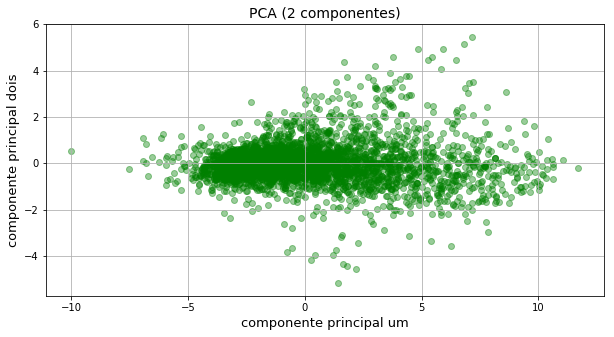

In [25]:
plt.figure(figsize=(10,5))
plt.title("PCA (2 componentes)", fontsize=14)
plt.xlabel("componente principal um", fontsize=13)
plt.ylabel("componente principal dois", fontsize=13)
plt.grid()
plt.scatter(X_pca[:,0], X_pca[:,1], color="green", alpha=.4);

- vou trocar a dimensionalidade de cada gen, por uma dimesionalidade de 3x3, para assim ver o gen como uma imagem.

In [26]:
X_img = np.array(X_train).reshape((X_train.shape[0],3,3,1))
X_img = (X_img - np.mean(X_img))/np.mean(X_img)
X_lab = X_train.index

----------------------------- Genomas representados na forma de uma imagem -----------------------------


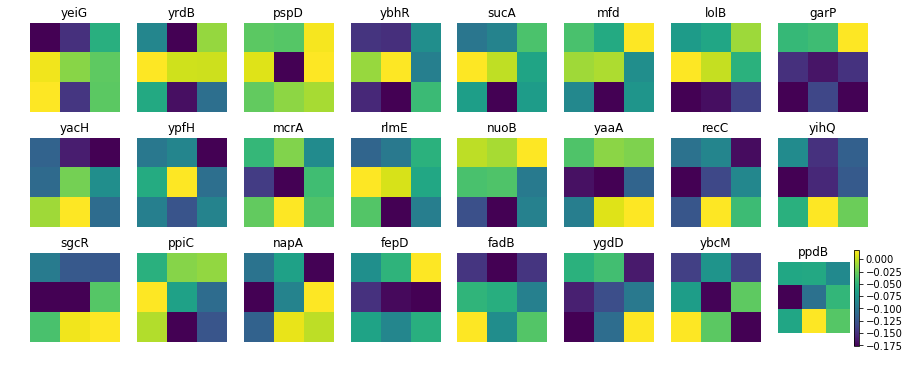

In [83]:
idx = np.random.randint(low=0, high=X_train.shape[0], size=24)
imgs =  X_img[idx]
titles = X_lab[idx]
fig = plt.figure(figsize=(15,6))
p=0
#plt.title("Genomas representados na forma de uma imagem", fontsize=12)
plt.axis("off");
print("----------------------------- Genomas representados na forma de uma imagem -----------------------------")
for i in imgs:
    ax=fig.add_subplot(3,8,p+1)
    plt.title(titles[p])
    plt.imshow(i.reshape(3,3))
    plt.axis("off");
    p += 1
plt.colorbar(ax=ax);

In [67]:
class GANs():
    #inialização dos parâmetros
    def __init__(self, width, height, channels, noise_input):
        self.width = width
        self.height = height
        self.channels = channels
        self.dim = (self.width, self.height, self.channels)
        self.noise_input = noise_input
        self.g_loss = []
        self.d_loss = []
        self.g_lpe = []
        self.d_lpe = []
        #self.optimizer = Adam(lr=0.0001, beta_1=0.5)
        self.optimizerD = Adam(lr=0.0001, beta_1=0.5)
        self.optimizerG = Adam(lr=0.0004, beta_1=0.5)
        self.G = self.noise_generator()
        print("Compilando o gerador...")
        self.G.compile(loss='binary_crossentropy', optimizer=self.optimizerG)
        self.D = self.discriminator()
        print("Compilando o discriminador...")
        self.D.compile(loss='binary_crossentropy', optimizer=self.optimizerD, metrics=['accuracy'])
        self.stacked_generator_discriminator = Sequential()
        self.stacked_generator_discriminator.add(self.G)
        self.stacked_generator_discriminator.add(self.D)
        self.D.trainable = False
        self.stacked_generator_discriminator.compile(loss='binary_crossentropy', optimizer=self.optimizerG)
        
    #criação do gerador de imagens fake
    def noise_generator(self):
        model = Sequential()
        model.add(Dense(16, input_shape=(self.noise_input,)))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(32))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(64))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(self.width*self.height*self.channels, activation="tanh"))
        model.add(Reshape((self.width, self.height, self.channels)))
        return model
    
    #criação do discriminador
    def discriminator(self):
        model = Sequential()
        model.add(Dense(64, input_shape=self.dim))
        model.add(LeakyReLU(alpha=0.2)) #función rectificadora
        model.add(Dense(32))
        model.add(LeakyReLU(alpha=0.2)) #función rectificadora
        model.add(Dense(16))
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))
        
        return model

    #Para obter o sumary do gerador
    def summary_gerador(self):
        return self.G.summary()
    
    #Para obter o sumary do gerador
    def summary_discriminador(self):
        return self.D.summary()
        
    #pra obter os batches pra o treino
    def get_batches(self, X_train, batch_size):
        """
        X_train: dataset para o treino
        epochs: quantidade de epocas para o treino do gradiente
        batch: tamanho to batch pra o treino de cada epochs
        """
        batches = []
        num_bat = int(np.ceil(X_train.shape[0]/batch_size))
        lim_i = 0
        lim_s = batch_size
        for i in range(num_bat):
            if lim_s > X_train.shape[0]:
                lim_s = X_train.shape[0]
            batches.append(X_train[lim_i:lim_s])
            lim_i += batch_size
            lim_s += batch_size
            
        return batches
        
    #devolve o loss do gerador e do discriminador
    def get_loss(self):
        return [self.g_loss, self.d_loss]
    
    #treinamento da GAN
    def train(self, X_train, epochs, batch_size):
        self.d_loss = []
        self.g_loss = []
        for cnt in range(epochs):
            batches = self.get_batches(X_train, batch_size)
            count_b = 0
            t_i = time()
            for batch in batches:
                gen_noise = np.random.normal(0, 1, (np.int64(batch.shape[0]), self.noise_input))
                #gerando as imagens fake
                syntetic_images = self.G.predict(gen_noise)
                #criação do array de treinamento
                x_combined_batch = np.concatenate((batch, syntetic_images))
                y_combined_batch = np.concatenate((np.ones((batch.shape[0], 1)),
                                                   np.zeros((batch.shape[0], 1))))
                #treino do discriminador
                d_l = self.D.train_on_batch(x_combined_batch, y_combined_batch)
                self.d_loss.append(d_l[0])
                # train generator
                noise = np.random.normal(0, 1, (batch.shape[0], self.noise_input))
                y_mislabled = np.ones((batch.shape[0], 1))

                g_l = self.stacked_generator_discriminator.train_on_batch(noise, y_mislabled)
                self.g_loss.append(g_l)
                count_b += 1
                if (count_b%20)==0:
                    t_f = time()
                    t = t_f - t_i
                    t_i = time()
                    print ('epoch:[%d/%d] batch:[%d/%d], [Discriminator::d_loss: %f], [Generator::loss: %f], %f[sec]'
                               % (cnt+1,epochs,count_b,len(batches),d_l[0],g_l,t))
            self.g_lpe.append(g_l)
            self.d_lpe.append(d_l[0])

In [68]:
gan = GANs(width=3, height=3, channels=1, noise_input=100)

Compilando o gerador...
Compilando o discriminador...


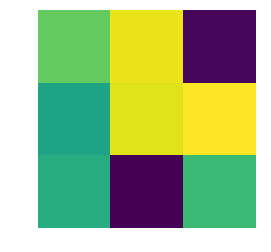

In [69]:
img_p = gan.G.predict(np.random.normal(0,1,(1,100)))
plt.imshow(img_p.reshape(3,3));
plt.axis("off");

In [70]:
gan.train(X_img, epochs=500,batch_size=16)

/home/ejrueda/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


epoch:[1/500] batch:[20/254], [Discriminator::d_loss: 0.708801], [Generator::loss: 0.669075], 1.693506[sec]
epoch:[1/500] batch:[40/254], [Discriminator::d_loss: 0.707124], [Generator::loss: 0.656224], 0.051725[sec]
epoch:[1/500] batch:[60/254], [Discriminator::d_loss: 0.704508], [Generator::loss: 0.667142], 0.050817[sec]
epoch:[1/500] batch:[80/254], [Discriminator::d_loss: 0.706046], [Generator::loss: 0.681284], 0.051156[sec]
epoch:[1/500] batch:[100/254], [Discriminator::d_loss: 0.691746], [Generator::loss: 0.709437], 0.053833[sec]
epoch:[1/500] batch:[120/254], [Discriminator::d_loss: 0.680347], [Generator::loss: 0.726124], 0.056967[sec]
epoch:[1/500] batch:[140/254], [Discriminator::d_loss: 0.681094], [Generator::loss: 0.713440], 0.051357[sec]
epoch:[1/500] batch:[160/254], [Discriminator::d_loss: 0.678746], [Generator::loss: 0.713081], 0.051316[sec]
epoch:[1/500] batch:[180/254], [Discriminator::d_loss: 0.676250], [Generator::loss: 0.718759], 0.057463[sec]
epoch:[1/500] batch:[20

epoch:[7/500] batch:[100/254], [Discriminator::d_loss: 0.692435], [Generator::loss: 0.692720], 0.051756[sec]
epoch:[7/500] batch:[120/254], [Discriminator::d_loss: 0.696401], [Generator::loss: 0.688221], 0.061023[sec]
epoch:[7/500] batch:[140/254], [Discriminator::d_loss: 0.693625], [Generator::loss: 0.692548], 0.051153[sec]
epoch:[7/500] batch:[160/254], [Discriminator::d_loss: 0.692731], [Generator::loss: 0.692780], 0.050817[sec]
epoch:[7/500] batch:[180/254], [Discriminator::d_loss: 0.692823], [Generator::loss: 0.693667], 0.054765[sec]
epoch:[7/500] batch:[200/254], [Discriminator::d_loss: 0.693133], [Generator::loss: 0.692151], 0.055728[sec]
epoch:[7/500] batch:[220/254], [Discriminator::d_loss: 0.693393], [Generator::loss: 0.692553], 0.052290[sec]
epoch:[7/500] batch:[240/254], [Discriminator::d_loss: 0.693185], [Generator::loss: 0.692591], 0.051499[sec]
epoch:[8/500] batch:[20/254], [Discriminator::d_loss: 0.693591], [Generator::loss: 0.694046], 0.058326[sec]
epoch:[8/500] batch:

epoch:[13/500] batch:[180/254], [Discriminator::d_loss: 0.688875], [Generator::loss: 0.700986], 0.051867[sec]
epoch:[13/500] batch:[200/254], [Discriminator::d_loss: 0.693015], [Generator::loss: 0.691247], 0.056199[sec]
epoch:[13/500] batch:[220/254], [Discriminator::d_loss: 0.697785], [Generator::loss: 0.689613], 0.051178[sec]
epoch:[13/500] batch:[240/254], [Discriminator::d_loss: 0.693100], [Generator::loss: 0.694630], 0.051275[sec]
epoch:[14/500] batch:[20/254], [Discriminator::d_loss: 0.693934], [Generator::loss: 0.693707], 0.058172[sec]
epoch:[14/500] batch:[40/254], [Discriminator::d_loss: 0.690489], [Generator::loss: 0.693974], 0.051103[sec]
epoch:[14/500] batch:[60/254], [Discriminator::d_loss: 0.691783], [Generator::loss: 0.697030], 0.050969[sec]
epoch:[14/500] batch:[80/254], [Discriminator::d_loss: 0.691285], [Generator::loss: 0.694106], 0.050773[sec]
epoch:[14/500] batch:[100/254], [Discriminator::d_loss: 0.696378], [Generator::loss: 0.690868], 0.052272[sec]
epoch:[14/500]

epoch:[20/500] batch:[60/254], [Discriminator::d_loss: 0.691511], [Generator::loss: 0.694953], 0.061850[sec]
epoch:[20/500] batch:[80/254], [Discriminator::d_loss: 0.692286], [Generator::loss: 0.694986], 0.051963[sec]
epoch:[20/500] batch:[100/254], [Discriminator::d_loss: 0.693218], [Generator::loss: 0.694406], 0.052740[sec]
epoch:[20/500] batch:[120/254], [Discriminator::d_loss: 0.692838], [Generator::loss: 0.693001], 0.051760[sec]
epoch:[20/500] batch:[140/254], [Discriminator::d_loss: 0.693276], [Generator::loss: 0.692734], 0.089281[sec]
epoch:[20/500] batch:[160/254], [Discriminator::d_loss: 0.694285], [Generator::loss: 0.691936], 0.094067[sec]
epoch:[20/500] batch:[180/254], [Discriminator::d_loss: 0.694301], [Generator::loss: 0.691472], 0.055649[sec]
epoch:[20/500] batch:[200/254], [Discriminator::d_loss: 0.690297], [Generator::loss: 0.696179], 0.052092[sec]
epoch:[20/500] batch:[220/254], [Discriminator::d_loss: 0.692891], [Generator::loss: 0.693560], 0.058040[sec]
epoch:[20/50

epoch:[26/500] batch:[120/254], [Discriminator::d_loss: 0.690862], [Generator::loss: 0.697772], 0.055082[sec]
epoch:[26/500] batch:[140/254], [Discriminator::d_loss: 0.690441], [Generator::loss: 0.693688], 0.062288[sec]
epoch:[26/500] batch:[160/254], [Discriminator::d_loss: 0.697040], [Generator::loss: 0.691867], 0.051584[sec]
epoch:[26/500] batch:[180/254], [Discriminator::d_loss: 0.693633], [Generator::loss: 0.693257], 0.050909[sec]
epoch:[26/500] batch:[200/254], [Discriminator::d_loss: 0.693291], [Generator::loss: 0.693466], 0.056263[sec]
epoch:[26/500] batch:[220/254], [Discriminator::d_loss: 0.693744], [Generator::loss: 0.693079], 0.052561[sec]
epoch:[26/500] batch:[240/254], [Discriminator::d_loss: 0.693807], [Generator::loss: 0.692241], 0.050965[sec]
epoch:[27/500] batch:[20/254], [Discriminator::d_loss: 0.693236], [Generator::loss: 0.694642], 0.050872[sec]
epoch:[27/500] batch:[40/254], [Discriminator::d_loss: 0.681869], [Generator::loss: 0.695270], 0.056402[sec]
epoch:[27/50

epoch:[32/500] batch:[200/254], [Discriminator::d_loss: 0.693987], [Generator::loss: 0.689745], 0.055664[sec]
epoch:[32/500] batch:[220/254], [Discriminator::d_loss: 0.691927], [Generator::loss: 0.695083], 0.055519[sec]
epoch:[32/500] batch:[240/254], [Discriminator::d_loss: 0.689968], [Generator::loss: 0.695876], 0.053988[sec]
epoch:[33/500] batch:[20/254], [Discriminator::d_loss: 0.694022], [Generator::loss: 0.690617], 0.050878[sec]
epoch:[33/500] batch:[40/254], [Discriminator::d_loss: 0.688630], [Generator::loss: 0.696375], 0.066740[sec]
epoch:[33/500] batch:[60/254], [Discriminator::d_loss: 0.696355], [Generator::loss: 0.693066], 0.052125[sec]
epoch:[33/500] batch:[80/254], [Discriminator::d_loss: 0.691848], [Generator::loss: 0.693222], 0.051221[sec]
epoch:[33/500] batch:[100/254], [Discriminator::d_loss: 0.693048], [Generator::loss: 0.694570], 0.051126[sec]
epoch:[33/500] batch:[120/254], [Discriminator::d_loss: 0.693779], [Generator::loss: 0.694065], 0.054983[sec]
epoch:[33/500]

epoch:[39/500] batch:[20/254], [Discriminator::d_loss: 0.691697], [Generator::loss: 0.692108], 0.050707[sec]
epoch:[39/500] batch:[40/254], [Discriminator::d_loss: 0.695730], [Generator::loss: 0.689266], 0.065404[sec]
epoch:[39/500] batch:[60/254], [Discriminator::d_loss: 0.693832], [Generator::loss: 0.692053], 0.050816[sec]
epoch:[39/500] batch:[80/254], [Discriminator::d_loss: 0.692094], [Generator::loss: 0.694268], 0.050716[sec]
epoch:[39/500] batch:[100/254], [Discriminator::d_loss: 0.693356], [Generator::loss: 0.693841], 0.057089[sec]
epoch:[39/500] batch:[120/254], [Discriminator::d_loss: 0.693978], [Generator::loss: 0.692152], 0.052920[sec]
epoch:[39/500] batch:[140/254], [Discriminator::d_loss: 0.693475], [Generator::loss: 0.693180], 0.051747[sec]
epoch:[39/500] batch:[160/254], [Discriminator::d_loss: 0.693879], [Generator::loss: 0.694514], 0.050809[sec]
epoch:[39/500] batch:[180/254], [Discriminator::d_loss: 0.692811], [Generator::loss: 0.693937], 0.052287[sec]
epoch:[39/500]

epoch:[45/500] batch:[100/254], [Discriminator::d_loss: 0.693738], [Generator::loss: 0.694535], 0.059077[sec]
epoch:[45/500] batch:[120/254], [Discriminator::d_loss: 0.695635], [Generator::loss: 0.691613], 0.055794[sec]
epoch:[45/500] batch:[140/254], [Discriminator::d_loss: 0.693494], [Generator::loss: 0.691740], 0.050570[sec]
epoch:[45/500] batch:[160/254], [Discriminator::d_loss: 0.694305], [Generator::loss: 0.693572], 0.050639[sec]
epoch:[45/500] batch:[180/254], [Discriminator::d_loss: 0.692220], [Generator::loss: 0.694297], 0.055662[sec]
epoch:[45/500] batch:[200/254], [Discriminator::d_loss: 0.692029], [Generator::loss: 0.693945], 0.052916[sec]
epoch:[45/500] batch:[220/254], [Discriminator::d_loss: 0.692653], [Generator::loss: 0.694208], 0.051112[sec]
epoch:[45/500] batch:[240/254], [Discriminator::d_loss: 0.693453], [Generator::loss: 0.693036], 0.050676[sec]
epoch:[46/500] batch:[20/254], [Discriminator::d_loss: 0.696932], [Generator::loss: 0.692897], 0.059042[sec]
epoch:[46/5

epoch:[51/500] batch:[180/254], [Discriminator::d_loss: 0.692248], [Generator::loss: 0.694308], 0.059794[sec]
epoch:[51/500] batch:[200/254], [Discriminator::d_loss: 0.692548], [Generator::loss: 0.692833], 0.056295[sec]
epoch:[51/500] batch:[220/254], [Discriminator::d_loss: 0.693049], [Generator::loss: 0.692395], 0.051292[sec]
epoch:[51/500] batch:[240/254], [Discriminator::d_loss: 0.693740], [Generator::loss: 0.691994], 0.051340[sec]
epoch:[52/500] batch:[20/254], [Discriminator::d_loss: 0.692745], [Generator::loss: 0.695372], 0.058889[sec]
epoch:[52/500] batch:[40/254], [Discriminator::d_loss: 0.687963], [Generator::loss: 0.695551], 0.051323[sec]
epoch:[52/500] batch:[60/254], [Discriminator::d_loss: 0.697870], [Generator::loss: 0.691995], 0.051473[sec]
epoch:[52/500] batch:[80/254], [Discriminator::d_loss: 0.692545], [Generator::loss: 0.697599], 0.051501[sec]
epoch:[52/500] batch:[100/254], [Discriminator::d_loss: 0.691301], [Generator::loss: 0.694234], 0.053786[sec]
epoch:[52/500]

epoch:[58/500] batch:[20/254], [Discriminator::d_loss: 0.695030], [Generator::loss: 0.693505], 0.061628[sec]
epoch:[58/500] batch:[40/254], [Discriminator::d_loss: 0.686343], [Generator::loss: 0.697258], 0.062685[sec]
epoch:[58/500] batch:[60/254], [Discriminator::d_loss: 0.697274], [Generator::loss: 0.691091], 0.061211[sec]
epoch:[58/500] batch:[80/254], [Discriminator::d_loss: 0.691875], [Generator::loss: 0.693334], 0.053749[sec]
epoch:[58/500] batch:[100/254], [Discriminator::d_loss: 0.692613], [Generator::loss: 0.693525], 0.070950[sec]
epoch:[58/500] batch:[120/254], [Discriminator::d_loss: 0.694472], [Generator::loss: 0.691869], 0.052191[sec]
epoch:[58/500] batch:[140/254], [Discriminator::d_loss: 0.693769], [Generator::loss: 0.692638], 0.050757[sec]
epoch:[58/500] batch:[160/254], [Discriminator::d_loss: 0.693787], [Generator::loss: 0.693642], 0.053056[sec]
epoch:[58/500] batch:[180/254], [Discriminator::d_loss: 0.692449], [Generator::loss: 0.694873], 0.053672[sec]
epoch:[58/500]

epoch:[64/500] batch:[100/254], [Discriminator::d_loss: 0.695136], [Generator::loss: 0.692358], 0.053219[sec]
epoch:[64/500] batch:[120/254], [Discriminator::d_loss: 0.695845], [Generator::loss: 0.692314], 0.051991[sec]
epoch:[64/500] batch:[140/254], [Discriminator::d_loss: 0.693572], [Generator::loss: 0.693690], 0.051860[sec]
epoch:[64/500] batch:[160/254], [Discriminator::d_loss: 0.691481], [Generator::loss: 0.695106], 0.051788[sec]
epoch:[64/500] batch:[180/254], [Discriminator::d_loss: 0.692056], [Generator::loss: 0.694641], 0.053174[sec]
epoch:[64/500] batch:[200/254], [Discriminator::d_loss: 0.694236], [Generator::loss: 0.691717], 0.052289[sec]
epoch:[64/500] batch:[220/254], [Discriminator::d_loss: 0.694583], [Generator::loss: 0.691901], 0.053051[sec]
epoch:[64/500] batch:[240/254], [Discriminator::d_loss: 0.692993], [Generator::loss: 0.694131], 0.052028[sec]
epoch:[65/500] batch:[20/254], [Discriminator::d_loss: 0.693093], [Generator::loss: 0.692127], 0.052367[sec]
epoch:[65/5

epoch:[70/500] batch:[180/254], [Discriminator::d_loss: 0.691522], [Generator::loss: 0.695643], 0.053134[sec]
epoch:[70/500] batch:[200/254], [Discriminator::d_loss: 0.693542], [Generator::loss: 0.689371], 0.079161[sec]
epoch:[70/500] batch:[220/254], [Discriminator::d_loss: 0.695214], [Generator::loss: 0.689775], 0.064041[sec]
epoch:[70/500] batch:[240/254], [Discriminator::d_loss: 0.692346], [Generator::loss: 0.693290], 0.052241[sec]
epoch:[71/500] batch:[20/254], [Discriminator::d_loss: 0.692995], [Generator::loss: 0.691785], 0.055343[sec]
epoch:[71/500] batch:[40/254], [Discriminator::d_loss: 0.692156], [Generator::loss: 0.693709], 0.051765[sec]
epoch:[71/500] batch:[60/254], [Discriminator::d_loss: 0.693444], [Generator::loss: 0.693749], 0.053046[sec]
epoch:[71/500] batch:[80/254], [Discriminator::d_loss: 0.692602], [Generator::loss: 0.692593], 0.052112[sec]
epoch:[71/500] batch:[100/254], [Discriminator::d_loss: 0.693489], [Generator::loss: 0.693808], 0.053540[sec]
epoch:[71/500]

epoch:[77/500] batch:[20/254], [Discriminator::d_loss: 0.693089], [Generator::loss: 0.695906], 0.061539[sec]
epoch:[77/500] batch:[40/254], [Discriminator::d_loss: 0.685145], [Generator::loss: 0.698141], 0.063082[sec]
epoch:[77/500] batch:[60/254], [Discriminator::d_loss: 0.699619], [Generator::loss: 0.690334], 0.061921[sec]
epoch:[77/500] batch:[80/254], [Discriminator::d_loss: 0.688797], [Generator::loss: 0.696602], 0.061280[sec]
epoch:[77/500] batch:[100/254], [Discriminator::d_loss: 0.690809], [Generator::loss: 0.696310], 0.062824[sec]
epoch:[77/500] batch:[120/254], [Discriminator::d_loss: 0.695912], [Generator::loss: 0.691734], 0.062429[sec]
epoch:[77/500] batch:[140/254], [Discriminator::d_loss: 0.694308], [Generator::loss: 0.692327], 0.062312[sec]
epoch:[77/500] batch:[160/254], [Discriminator::d_loss: 0.693476], [Generator::loss: 0.693049], 0.060904[sec]
epoch:[77/500] batch:[180/254], [Discriminator::d_loss: 0.692693], [Generator::loss: 0.693757], 0.063373[sec]
epoch:[77/500]

epoch:[83/500] batch:[100/254], [Discriminator::d_loss: 0.689732], [Generator::loss: 0.696170], 0.063323[sec]
epoch:[83/500] batch:[120/254], [Discriminator::d_loss: 0.693284], [Generator::loss: 0.693720], 0.062607[sec]
epoch:[83/500] batch:[140/254], [Discriminator::d_loss: 0.693842], [Generator::loss: 0.689171], 0.061310[sec]
epoch:[83/500] batch:[160/254], [Discriminator::d_loss: 0.695730], [Generator::loss: 0.691033], 0.064013[sec]
epoch:[83/500] batch:[180/254], [Discriminator::d_loss: 0.693728], [Generator::loss: 0.693540], 0.069856[sec]
epoch:[83/500] batch:[200/254], [Discriminator::d_loss: 0.693925], [Generator::loss: 0.691878], 0.062191[sec]
epoch:[83/500] batch:[220/254], [Discriminator::d_loss: 0.693320], [Generator::loss: 0.692792], 0.060282[sec]
epoch:[83/500] batch:[240/254], [Discriminator::d_loss: 0.692579], [Generator::loss: 0.694319], 0.062506[sec]
epoch:[84/500] batch:[20/254], [Discriminator::d_loss: 0.694009], [Generator::loss: 0.694760], 0.060588[sec]
epoch:[84/5

epoch:[89/500] batch:[180/254], [Discriminator::d_loss: 0.692523], [Generator::loss: 0.693630], 0.063730[sec]
epoch:[89/500] batch:[200/254], [Discriminator::d_loss: 0.696336], [Generator::loss: 0.691014], 0.061428[sec]
epoch:[89/500] batch:[220/254], [Discriminator::d_loss: 0.693050], [Generator::loss: 0.692551], 0.062409[sec]
epoch:[89/500] batch:[240/254], [Discriminator::d_loss: 0.692060], [Generator::loss: 0.695320], 0.061734[sec]
epoch:[90/500] batch:[20/254], [Discriminator::d_loss: 0.693216], [Generator::loss: 0.691367], 0.062393[sec]
epoch:[90/500] batch:[40/254], [Discriminator::d_loss: 0.691850], [Generator::loss: 0.694266], 0.063285[sec]
epoch:[90/500] batch:[60/254], [Discriminator::d_loss: 0.696900], [Generator::loss: 0.691580], 0.063872[sec]
epoch:[90/500] batch:[80/254], [Discriminator::d_loss: 0.693465], [Generator::loss: 0.693472], 0.063297[sec]
epoch:[90/500] batch:[100/254], [Discriminator::d_loss: 0.692802], [Generator::loss: 0.693215], 0.062025[sec]
epoch:[90/500]

epoch:[96/500] batch:[20/254], [Discriminator::d_loss: 0.693131], [Generator::loss: 0.693608], 0.062054[sec]
epoch:[96/500] batch:[40/254], [Discriminator::d_loss: 0.685390], [Generator::loss: 0.698312], 0.062808[sec]
epoch:[96/500] batch:[60/254], [Discriminator::d_loss: 0.696034], [Generator::loss: 0.692870], 0.062912[sec]
epoch:[96/500] batch:[80/254], [Discriminator::d_loss: 0.696507], [Generator::loss: 0.689061], 0.059918[sec]
epoch:[96/500] batch:[100/254], [Discriminator::d_loss: 0.693489], [Generator::loss: 0.695496], 0.063534[sec]
epoch:[96/500] batch:[120/254], [Discriminator::d_loss: 0.692060], [Generator::loss: 0.696591], 0.063020[sec]
epoch:[96/500] batch:[140/254], [Discriminator::d_loss: 0.690456], [Generator::loss: 0.695309], 0.061284[sec]
epoch:[96/500] batch:[160/254], [Discriminator::d_loss: 0.694360], [Generator::loss: 0.692894], 0.061812[sec]
epoch:[96/500] batch:[180/254], [Discriminator::d_loss: 0.693474], [Generator::loss: 0.693120], 0.064647[sec]
epoch:[96/500]

epoch:[102/500] batch:[100/254], [Discriminator::d_loss: 0.695140], [Generator::loss: 0.691933], 0.063814[sec]
epoch:[102/500] batch:[120/254], [Discriminator::d_loss: 0.695593], [Generator::loss: 0.692825], 0.061781[sec]
epoch:[102/500] batch:[140/254], [Discriminator::d_loss: 0.692877], [Generator::loss: 0.693556], 0.059846[sec]
epoch:[102/500] batch:[160/254], [Discriminator::d_loss: 0.692019], [Generator::loss: 0.694725], 0.061943[sec]
epoch:[102/500] batch:[180/254], [Discriminator::d_loss: 0.692009], [Generator::loss: 0.694576], 0.063026[sec]
epoch:[102/500] batch:[200/254], [Discriminator::d_loss: 0.692701], [Generator::loss: 0.692956], 0.061988[sec]
epoch:[102/500] batch:[220/254], [Discriminator::d_loss: 0.692997], [Generator::loss: 0.692909], 0.060168[sec]
epoch:[102/500] batch:[240/254], [Discriminator::d_loss: 0.694350], [Generator::loss: 0.692381], 0.062992[sec]
epoch:[103/500] batch:[20/254], [Discriminator::d_loss: 0.693554], [Generator::loss: 0.693895], 0.060638[sec]
ep

epoch:[108/500] batch:[180/254], [Discriminator::d_loss: 0.693264], [Generator::loss: 0.693751], 0.062820[sec]
epoch:[108/500] batch:[200/254], [Discriminator::d_loss: 0.693708], [Generator::loss: 0.692734], 0.061746[sec]
epoch:[108/500] batch:[220/254], [Discriminator::d_loss: 0.693822], [Generator::loss: 0.693065], 0.061750[sec]
epoch:[108/500] batch:[240/254], [Discriminator::d_loss: 0.692973], [Generator::loss: 0.693876], 0.061250[sec]
epoch:[109/500] batch:[20/254], [Discriminator::d_loss: 0.695832], [Generator::loss: 0.696089], 0.060888[sec]
epoch:[109/500] batch:[40/254], [Discriminator::d_loss: 0.687111], [Generator::loss: 0.697783], 0.062505[sec]
epoch:[109/500] batch:[60/254], [Discriminator::d_loss: 0.689589], [Generator::loss: 0.694775], 0.062547[sec]
epoch:[109/500] batch:[80/254], [Discriminator::d_loss: 0.691578], [Generator::loss: 0.694978], 0.062270[sec]
epoch:[109/500] batch:[100/254], [Discriminator::d_loss: 0.698573], [Generator::loss: 0.690342], 0.064460[sec]
epoch

epoch:[115/500] batch:[20/254], [Discriminator::d_loss: 0.692428], [Generator::loss: 0.699575], 0.060508[sec]
epoch:[115/500] batch:[40/254], [Discriminator::d_loss: 0.675650], [Generator::loss: 0.705579], 0.061546[sec]
epoch:[115/500] batch:[60/254], [Discriminator::d_loss: 0.705405], [Generator::loss: 0.686834], 0.062437[sec]
epoch:[115/500] batch:[80/254], [Discriminator::d_loss: 0.695585], [Generator::loss: 0.692039], 0.060094[sec]
epoch:[115/500] batch:[100/254], [Discriminator::d_loss: 0.691853], [Generator::loss: 0.690749], 0.062989[sec]
epoch:[115/500] batch:[120/254], [Discriminator::d_loss: 0.694974], [Generator::loss: 0.693984], 0.063479[sec]
epoch:[115/500] batch:[140/254], [Discriminator::d_loss: 0.691699], [Generator::loss: 0.693538], 0.062342[sec]
epoch:[115/500] batch:[160/254], [Discriminator::d_loss: 0.696199], [Generator::loss: 0.691270], 0.060323[sec]
epoch:[115/500] batch:[180/254], [Discriminator::d_loss: 0.694291], [Generator::loss: 0.693064], 0.062868[sec]
epoch

epoch:[121/500] batch:[100/254], [Discriminator::d_loss: 0.688883], [Generator::loss: 0.698923], 0.062141[sec]
epoch:[121/500] batch:[120/254], [Discriminator::d_loss: 0.694703], [Generator::loss: 0.689933], 0.061370[sec]
epoch:[121/500] batch:[140/254], [Discriminator::d_loss: 0.693175], [Generator::loss: 0.690762], 0.062926[sec]
epoch:[121/500] batch:[160/254], [Discriminator::d_loss: 0.695858], [Generator::loss: 0.692118], 0.061795[sec]
epoch:[121/500] batch:[180/254], [Discriminator::d_loss: 0.693792], [Generator::loss: 0.694402], 0.063024[sec]
epoch:[121/500] batch:[200/254], [Discriminator::d_loss: 0.692890], [Generator::loss: 0.694709], 0.062248[sec]
epoch:[121/500] batch:[220/254], [Discriminator::d_loss: 0.693443], [Generator::loss: 0.694117], 0.062897[sec]
epoch:[121/500] batch:[240/254], [Discriminator::d_loss: 0.692186], [Generator::loss: 0.696232], 0.063165[sec]
epoch:[122/500] batch:[20/254], [Discriminator::d_loss: 0.694274], [Generator::loss: 0.698100], 0.061178[sec]
ep

epoch:[127/500] batch:[180/254], [Discriminator::d_loss: 0.687893], [Generator::loss: 0.698315], 0.066696[sec]
epoch:[127/500] batch:[200/254], [Discriminator::d_loss: 0.692714], [Generator::loss: 0.688947], 0.062341[sec]
epoch:[127/500] batch:[220/254], [Discriminator::d_loss: 0.693843], [Generator::loss: 0.690604], 0.059578[sec]
epoch:[127/500] batch:[240/254], [Discriminator::d_loss: 0.695375], [Generator::loss: 0.691753], 0.060558[sec]
epoch:[128/500] batch:[20/254], [Discriminator::d_loss: 0.693664], [Generator::loss: 0.695698], 0.060711[sec]
epoch:[128/500] batch:[40/254], [Discriminator::d_loss: 0.685206], [Generator::loss: 0.700069], 0.062109[sec]
epoch:[128/500] batch:[60/254], [Discriminator::d_loss: 0.696522], [Generator::loss: 0.693365], 0.062553[sec]
epoch:[128/500] batch:[80/254], [Discriminator::d_loss: 0.694096], [Generator::loss: 0.688864], 0.060744[sec]
epoch:[128/500] batch:[100/254], [Discriminator::d_loss: 0.691718], [Generator::loss: 0.692639], 0.064119[sec]
epoch

epoch:[134/500] batch:[20/254], [Discriminator::d_loss: 0.693294], [Generator::loss: 0.692321], 0.065545[sec]
epoch:[134/500] batch:[40/254], [Discriminator::d_loss: 0.689116], [Generator::loss: 0.697053], 0.061019[sec]
epoch:[134/500] batch:[60/254], [Discriminator::d_loss: 0.697817], [Generator::loss: 0.692860], 0.060326[sec]
epoch:[134/500] batch:[80/254], [Discriminator::d_loss: 0.693821], [Generator::loss: 0.691577], 0.062530[sec]
epoch:[134/500] batch:[100/254], [Discriminator::d_loss: 0.692222], [Generator::loss: 0.694159], 0.062800[sec]
epoch:[134/500] batch:[120/254], [Discriminator::d_loss: 0.690845], [Generator::loss: 0.696356], 0.062866[sec]
epoch:[134/500] batch:[140/254], [Discriminator::d_loss: 0.688399], [Generator::loss: 0.695489], 0.060533[sec]
epoch:[134/500] batch:[160/254], [Discriminator::d_loss: 0.693536], [Generator::loss: 0.693578], 0.061250[sec]
epoch:[134/500] batch:[180/254], [Discriminator::d_loss: 0.692195], [Generator::loss: 0.693839], 0.064417[sec]
epoch

epoch:[140/500] batch:[100/254], [Discriminator::d_loss: 0.690902], [Generator::loss: 0.694738], 0.064767[sec]
epoch:[140/500] batch:[120/254], [Discriminator::d_loss: 0.694920], [Generator::loss: 0.692355], 0.064030[sec]
epoch:[140/500] batch:[140/254], [Discriminator::d_loss: 0.695044], [Generator::loss: 0.689634], 0.063948[sec]
epoch:[140/500] batch:[160/254], [Discriminator::d_loss: 0.699167], [Generator::loss: 0.689695], 0.064218[sec]
epoch:[140/500] batch:[180/254], [Discriminator::d_loss: 0.697349], [Generator::loss: 0.689635], 0.065091[sec]
epoch:[140/500] batch:[200/254], [Discriminator::d_loss: 0.688121], [Generator::loss: 0.702189], 0.062815[sec]
epoch:[140/500] batch:[220/254], [Discriminator::d_loss: 0.689209], [Generator::loss: 0.694749], 0.064598[sec]
epoch:[140/500] batch:[240/254], [Discriminator::d_loss: 0.694999], [Generator::loss: 0.691123], 0.062193[sec]
epoch:[141/500] batch:[20/254], [Discriminator::d_loss: 0.687770], [Generator::loss: 0.702046], 0.057381[sec]
ep

epoch:[146/500] batch:[180/254], [Discriminator::d_loss: 0.700011], [Generator::loss: 0.687642], 0.055184[sec]
epoch:[146/500] batch:[200/254], [Discriminator::d_loss: 0.691598], [Generator::loss: 0.699168], 0.054479[sec]
epoch:[146/500] batch:[220/254], [Discriminator::d_loss: 0.682126], [Generator::loss: 0.704609], 0.054770[sec]
epoch:[146/500] batch:[240/254], [Discriminator::d_loss: 0.691138], [Generator::loss: 0.691650], 0.053798[sec]
epoch:[147/500] batch:[20/254], [Discriminator::d_loss: 0.697601], [Generator::loss: 0.688400], 0.053252[sec]
epoch:[147/500] batch:[40/254], [Discriminator::d_loss: 0.693910], [Generator::loss: 0.695490], 0.053738[sec]
epoch:[147/500] batch:[60/254], [Discriminator::d_loss: 0.687105], [Generator::loss: 0.700539], 0.055689[sec]
epoch:[147/500] batch:[80/254], [Discriminator::d_loss: 0.691625], [Generator::loss: 0.693395], 0.059958[sec]
epoch:[147/500] batch:[100/254], [Discriminator::d_loss: 0.696521], [Generator::loss: 0.690672], 0.055061[sec]
epoch

epoch:[153/500] batch:[20/254], [Discriminator::d_loss: 0.691582], [Generator::loss: 0.694927], 0.052405[sec]
epoch:[153/500] batch:[40/254], [Discriminator::d_loss: 0.686945], [Generator::loss: 0.697620], 0.052587[sec]
epoch:[153/500] batch:[60/254], [Discriminator::d_loss: 0.697281], [Generator::loss: 0.685450], 0.053763[sec]
epoch:[153/500] batch:[80/254], [Discriminator::d_loss: 0.696616], [Generator::loss: 0.688374], 0.052351[sec]
epoch:[153/500] batch:[100/254], [Discriminator::d_loss: 0.691532], [Generator::loss: 0.695808], 0.053729[sec]
epoch:[153/500] batch:[120/254], [Discriminator::d_loss: 0.694074], [Generator::loss: 0.693086], 0.052038[sec]
epoch:[153/500] batch:[140/254], [Discriminator::d_loss: 0.692548], [Generator::loss: 0.693296], 0.053954[sec]
epoch:[153/500] batch:[160/254], [Discriminator::d_loss: 0.695159], [Generator::loss: 0.694039], 0.053355[sec]
epoch:[153/500] batch:[180/254], [Discriminator::d_loss: 0.693298], [Generator::loss: 0.695038], 0.067757[sec]
epoch

epoch:[159/500] batch:[100/254], [Discriminator::d_loss: 0.692260], [Generator::loss: 0.691885], 0.059937[sec]
epoch:[159/500] batch:[120/254], [Discriminator::d_loss: 0.694975], [Generator::loss: 0.690877], 0.059602[sec]
epoch:[159/500] batch:[140/254], [Discriminator::d_loss: 0.693592], [Generator::loss: 0.692105], 0.058581[sec]
epoch:[159/500] batch:[160/254], [Discriminator::d_loss: 0.693956], [Generator::loss: 0.693776], 0.056907[sec]
epoch:[159/500] batch:[180/254], [Discriminator::d_loss: 0.692758], [Generator::loss: 0.692648], 0.059351[sec]
epoch:[159/500] batch:[200/254], [Discriminator::d_loss: 0.691731], [Generator::loss: 0.693859], 0.061770[sec]
epoch:[159/500] batch:[220/254], [Discriminator::d_loss: 0.691565], [Generator::loss: 0.694206], 0.064498[sec]
epoch:[159/500] batch:[240/254], [Discriminator::d_loss: 0.693822], [Generator::loss: 0.693657], 0.069986[sec]
epoch:[160/500] batch:[20/254], [Discriminator::d_loss: 0.694256], [Generator::loss: 0.694116], 0.063402[sec]
ep

epoch:[165/500] batch:[220/254], [Discriminator::d_loss: 0.690603], [Generator::loss: 0.695060], 0.084649[sec]
epoch:[165/500] batch:[240/254], [Discriminator::d_loss: 0.692223], [Generator::loss: 0.693274], 0.090726[sec]
epoch:[166/500] batch:[20/254], [Discriminator::d_loss: 0.693144], [Generator::loss: 0.694973], 0.095268[sec]
epoch:[166/500] batch:[40/254], [Discriminator::d_loss: 0.682349], [Generator::loss: 0.696178], 0.103634[sec]
epoch:[166/500] batch:[60/254], [Discriminator::d_loss: 0.702886], [Generator::loss: 0.682958], 0.066331[sec]
epoch:[166/500] batch:[80/254], [Discriminator::d_loss: 0.689696], [Generator::loss: 0.697634], 0.069000[sec]
epoch:[166/500] batch:[100/254], [Discriminator::d_loss: 0.692677], [Generator::loss: 0.691627], 0.076610[sec]
epoch:[166/500] batch:[120/254], [Discriminator::d_loss: 0.695132], [Generator::loss: 0.692229], 0.066905[sec]
epoch:[166/500] batch:[140/254], [Discriminator::d_loss: 0.693940], [Generator::loss: 0.692863], 0.077194[sec]
epoch

epoch:[172/500] batch:[80/254], [Discriminator::d_loss: 0.689159], [Generator::loss: 0.696189], 0.085672[sec]
epoch:[172/500] batch:[100/254], [Discriminator::d_loss: 0.694150], [Generator::loss: 0.692532], 0.066605[sec]
epoch:[172/500] batch:[120/254], [Discriminator::d_loss: 0.693690], [Generator::loss: 0.693301], 0.083000[sec]
epoch:[172/500] batch:[140/254], [Discriminator::d_loss: 0.693666], [Generator::loss: 0.694012], 0.062541[sec]
epoch:[172/500] batch:[160/254], [Discriminator::d_loss: 0.699131], [Generator::loss: 0.689869], 0.060629[sec]
epoch:[172/500] batch:[180/254], [Discriminator::d_loss: 0.699166], [Generator::loss: 0.690005], 0.058752[sec]
epoch:[172/500] batch:[200/254], [Discriminator::d_loss: 0.691682], [Generator::loss: 0.694202], 0.058269[sec]
epoch:[172/500] batch:[220/254], [Discriminator::d_loss: 0.691284], [Generator::loss: 0.695140], 0.058278[sec]
epoch:[172/500] batch:[240/254], [Discriminator::d_loss: 0.693996], [Generator::loss: 0.694111], 0.056842[sec]
ep

epoch:[178/500] batch:[180/254], [Discriminator::d_loss: 0.693533], [Generator::loss: 0.691999], 0.058305[sec]
epoch:[178/500] batch:[200/254], [Discriminator::d_loss: 0.692188], [Generator::loss: 0.693737], 0.060430[sec]
epoch:[178/500] batch:[220/254], [Discriminator::d_loss: 0.690990], [Generator::loss: 0.693941], 0.057665[sec]
epoch:[178/500] batch:[240/254], [Discriminator::d_loss: 0.692548], [Generator::loss: 0.693792], 0.062817[sec]
epoch:[179/500] batch:[20/254], [Discriminator::d_loss: 0.692566], [Generator::loss: 0.696072], 0.068034[sec]
epoch:[179/500] batch:[40/254], [Discriminator::d_loss: 0.683652], [Generator::loss: 0.693170], 0.078944[sec]
epoch:[179/500] batch:[60/254], [Discriminator::d_loss: 0.696789], [Generator::loss: 0.694301], 0.069342[sec]
epoch:[179/500] batch:[80/254], [Discriminator::d_loss: 0.690855], [Generator::loss: 0.699355], 0.069370[sec]
epoch:[179/500] batch:[100/254], [Discriminator::d_loss: 0.693266], [Generator::loss: 0.692284], 0.057498[sec]
epoch

epoch:[184/500] batch:[240/254], [Discriminator::d_loss: 0.693485], [Generator::loss: 0.694724], 0.065091[sec]
epoch:[185/500] batch:[20/254], [Discriminator::d_loss: 0.693433], [Generator::loss: 0.701091], 0.056016[sec]
epoch:[185/500] batch:[40/254], [Discriminator::d_loss: 0.692650], [Generator::loss: 0.679387], 0.057230[sec]
epoch:[185/500] batch:[60/254], [Discriminator::d_loss: 0.698594], [Generator::loss: 0.692856], 0.060636[sec]
epoch:[185/500] batch:[80/254], [Discriminator::d_loss: 0.692964], [Generator::loss: 0.691788], 0.058316[sec]
epoch:[185/500] batch:[100/254], [Discriminator::d_loss: 0.693167], [Generator::loss: 0.691664], 0.055447[sec]
epoch:[185/500] batch:[120/254], [Discriminator::d_loss: 0.694284], [Generator::loss: 0.693637], 0.073345[sec]
epoch:[185/500] batch:[140/254], [Discriminator::d_loss: 0.693038], [Generator::loss: 0.694645], 0.074896[sec]
epoch:[185/500] batch:[160/254], [Discriminator::d_loss: 0.691726], [Generator::loss: 0.697448], 0.073904[sec]
epoch

epoch:[191/500] batch:[100/254], [Discriminator::d_loss: 0.694346], [Generator::loss: 0.689910], 0.058945[sec]
epoch:[191/500] batch:[120/254], [Discriminator::d_loss: 0.695863], [Generator::loss: 0.691192], 0.057410[sec]
epoch:[191/500] batch:[140/254], [Discriminator::d_loss: 0.693059], [Generator::loss: 0.693368], 0.058446[sec]
epoch:[191/500] batch:[160/254], [Discriminator::d_loss: 0.693218], [Generator::loss: 0.694377], 0.056874[sec]
epoch:[191/500] batch:[180/254], [Discriminator::d_loss: 0.692646], [Generator::loss: 0.694386], 0.062246[sec]
epoch:[191/500] batch:[200/254], [Discriminator::d_loss: 0.693201], [Generator::loss: 0.692420], 0.057070[sec]
epoch:[191/500] batch:[220/254], [Discriminator::d_loss: 0.693363], [Generator::loss: 0.691980], 0.056169[sec]
epoch:[191/500] batch:[240/254], [Discriminator::d_loss: 0.693718], [Generator::loss: 0.692557], 0.058819[sec]
epoch:[192/500] batch:[20/254], [Discriminator::d_loss: 0.693713], [Generator::loss: 0.693338], 0.056268[sec]
ep

epoch:[197/500] batch:[180/254], [Discriminator::d_loss: 0.692505], [Generator::loss: 0.694173], 0.056763[sec]
epoch:[197/500] batch:[200/254], [Discriminator::d_loss: 0.692959], [Generator::loss: 0.694145], 0.056505[sec]
epoch:[197/500] batch:[220/254], [Discriminator::d_loss: 0.693690], [Generator::loss: 0.692676], 0.058566[sec]
epoch:[197/500] batch:[240/254], [Discriminator::d_loss: 0.693837], [Generator::loss: 0.693086], 0.058060[sec]
epoch:[198/500] batch:[20/254], [Discriminator::d_loss: 0.691444], [Generator::loss: 0.694185], 0.058005[sec]
epoch:[198/500] batch:[40/254], [Discriminator::d_loss: 0.691396], [Generator::loss: 0.692368], 0.057227[sec]
epoch:[198/500] batch:[60/254], [Discriminator::d_loss: 0.694041], [Generator::loss: 0.692005], 0.055863[sec]
epoch:[198/500] batch:[80/254], [Discriminator::d_loss: 0.691734], [Generator::loss: 0.696496], 0.056555[sec]
epoch:[198/500] batch:[100/254], [Discriminator::d_loss: 0.690365], [Generator::loss: 0.695198], 0.059031[sec]
epoch

epoch:[204/500] batch:[20/254], [Discriminator::d_loss: 0.691132], [Generator::loss: 0.697327], 0.062608[sec]
epoch:[204/500] batch:[40/254], [Discriminator::d_loss: 0.682694], [Generator::loss: 0.700624], 0.061877[sec]
epoch:[204/500] batch:[60/254], [Discriminator::d_loss: 0.699439], [Generator::loss: 0.687077], 0.056427[sec]
epoch:[204/500] batch:[80/254], [Discriminator::d_loss: 0.697554], [Generator::loss: 0.689589], 0.056910[sec]
epoch:[204/500] batch:[100/254], [Discriminator::d_loss: 0.693142], [Generator::loss: 0.693965], 0.058488[sec]
epoch:[204/500] batch:[120/254], [Discriminator::d_loss: 0.693587], [Generator::loss: 0.692627], 0.057976[sec]
epoch:[204/500] batch:[140/254], [Discriminator::d_loss: 0.692823], [Generator::loss: 0.691937], 0.057397[sec]
epoch:[204/500] batch:[160/254], [Discriminator::d_loss: 0.694329], [Generator::loss: 0.692591], 0.056553[sec]
epoch:[204/500] batch:[180/254], [Discriminator::d_loss: 0.692573], [Generator::loss: 0.694310], 0.056869[sec]
epoch

epoch:[210/500] batch:[100/254], [Discriminator::d_loss: 0.694049], [Generator::loss: 0.692179], 0.063758[sec]
epoch:[210/500] batch:[120/254], [Discriminator::d_loss: 0.693513], [Generator::loss: 0.694322], 0.062658[sec]
epoch:[210/500] batch:[140/254], [Discriminator::d_loss: 0.693658], [Generator::loss: 0.694391], 0.065865[sec]
epoch:[210/500] batch:[160/254], [Discriminator::d_loss: 0.693126], [Generator::loss: 0.693675], 0.062417[sec]
epoch:[210/500] batch:[180/254], [Discriminator::d_loss: 0.698192], [Generator::loss: 0.685798], 0.064714[sec]
epoch:[210/500] batch:[200/254], [Discriminator::d_loss: 0.694809], [Generator::loss: 0.691124], 0.062886[sec]
epoch:[210/500] batch:[220/254], [Discriminator::d_loss: 0.688990], [Generator::loss: 0.695483], 0.062568[sec]
epoch:[210/500] batch:[240/254], [Discriminator::d_loss: 0.692502], [Generator::loss: 0.691684], 0.064304[sec]
epoch:[211/500] batch:[20/254], [Discriminator::d_loss: 0.692462], [Generator::loss: 0.695787], 0.080991[sec]
ep

epoch:[216/500] batch:[180/254], [Discriminator::d_loss: 0.691580], [Generator::loss: 0.691968], 0.059138[sec]
epoch:[216/500] batch:[200/254], [Discriminator::d_loss: 0.693606], [Generator::loss: 0.690621], 0.058589[sec]
epoch:[216/500] batch:[220/254], [Discriminator::d_loss: 0.695257], [Generator::loss: 0.690487], 0.057096[sec]
epoch:[216/500] batch:[240/254], [Discriminator::d_loss: 0.697000], [Generator::loss: 0.691191], 0.057227[sec]
epoch:[217/500] batch:[20/254], [Discriminator::d_loss: 0.692736], [Generator::loss: 0.697083], 0.056376[sec]
epoch:[217/500] batch:[40/254], [Discriminator::d_loss: 0.682843], [Generator::loss: 0.703581], 0.056715[sec]
epoch:[217/500] batch:[60/254], [Discriminator::d_loss: 0.693644], [Generator::loss: 0.698665], 0.057356[sec]
epoch:[217/500] batch:[80/254], [Discriminator::d_loss: 0.694823], [Generator::loss: 0.688285], 0.057114[sec]
epoch:[217/500] batch:[100/254], [Discriminator::d_loss: 0.697392], [Generator::loss: 0.688121], 0.061608[sec]
epoch

epoch:[223/500] batch:[20/254], [Discriminator::d_loss: 0.694188], [Generator::loss: 0.693023], 0.058012[sec]
epoch:[223/500] batch:[40/254], [Discriminator::d_loss: 0.685892], [Generator::loss: 0.698568], 0.057699[sec]
epoch:[223/500] batch:[60/254], [Discriminator::d_loss: 0.694166], [Generator::loss: 0.697090], 0.057118[sec]
epoch:[223/500] batch:[80/254], [Discriminator::d_loss: 0.692494], [Generator::loss: 0.691227], 0.057741[sec]
epoch:[223/500] batch:[100/254], [Discriminator::d_loss: 0.698728], [Generator::loss: 0.681515], 0.063625[sec]
epoch:[223/500] batch:[120/254], [Discriminator::d_loss: 0.693489], [Generator::loss: 0.694806], 0.057695[sec]
epoch:[223/500] batch:[140/254], [Discriminator::d_loss: 0.687083], [Generator::loss: 0.698688], 0.057217[sec]
epoch:[223/500] batch:[160/254], [Discriminator::d_loss: 0.693786], [Generator::loss: 0.691139], 0.057847[sec]
epoch:[223/500] batch:[180/254], [Discriminator::d_loss: 0.694356], [Generator::loss: 0.691925], 0.058620[sec]
epoch

epoch:[229/500] batch:[100/254], [Discriminator::d_loss: 0.699698], [Generator::loss: 0.689158], 0.058701[sec]
epoch:[229/500] batch:[120/254], [Discriminator::d_loss: 0.698545], [Generator::loss: 0.691313], 0.061212[sec]
epoch:[229/500] batch:[140/254], [Discriminator::d_loss: 0.695028], [Generator::loss: 0.694331], 0.056164[sec]
epoch:[229/500] batch:[160/254], [Discriminator::d_loss: 0.690140], [Generator::loss: 0.699063], 0.058321[sec]
epoch:[229/500] batch:[180/254], [Discriminator::d_loss: 0.689751], [Generator::loss: 0.700094], 0.059126[sec]
epoch:[229/500] batch:[200/254], [Discriminator::d_loss: 0.696955], [Generator::loss: 0.688903], 0.056729[sec]
epoch:[229/500] batch:[220/254], [Discriminator::d_loss: 0.687691], [Generator::loss: 0.698320], 0.057884[sec]
epoch:[229/500] batch:[240/254], [Discriminator::d_loss: 0.687160], [Generator::loss: 0.699219], 0.059124[sec]
epoch:[230/500] batch:[20/254], [Discriminator::d_loss: 0.694630], [Generator::loss: 0.689024], 0.057596[sec]
ep

epoch:[235/500] batch:[180/254], [Discriminator::d_loss: 0.691744], [Generator::loss: 0.696705], 0.058905[sec]
epoch:[235/500] batch:[200/254], [Discriminator::d_loss: 0.693165], [Generator::loss: 0.690827], 0.056062[sec]
epoch:[235/500] batch:[220/254], [Discriminator::d_loss: 0.695768], [Generator::loss: 0.689167], 0.058879[sec]
epoch:[235/500] batch:[240/254], [Discriminator::d_loss: 0.696386], [Generator::loss: 0.690262], 0.062225[sec]
epoch:[236/500] batch:[20/254], [Discriminator::d_loss: 0.691302], [Generator::loss: 0.693695], 0.056592[sec]
epoch:[236/500] batch:[40/254], [Discriminator::d_loss: 0.698182], [Generator::loss: 0.691354], 0.085427[sec]
epoch:[236/500] batch:[60/254], [Discriminator::d_loss: 0.692164], [Generator::loss: 0.692544], 0.071020[sec]
epoch:[236/500] batch:[80/254], [Discriminator::d_loss: 0.693495], [Generator::loss: 0.692659], 0.058104[sec]
epoch:[236/500] batch:[100/254], [Discriminator::d_loss: 0.694135], [Generator::loss: 0.693181], 0.059212[sec]
epoch

epoch:[242/500] batch:[20/254], [Discriminator::d_loss: 0.691387], [Generator::loss: 0.695000], 0.058760[sec]
epoch:[242/500] batch:[40/254], [Discriminator::d_loss: 0.690892], [Generator::loss: 0.694371], 0.057886[sec]
epoch:[242/500] batch:[60/254], [Discriminator::d_loss: 0.692586], [Generator::loss: 0.694129], 0.058395[sec]
epoch:[242/500] batch:[80/254], [Discriminator::d_loss: 0.691237], [Generator::loss: 0.693367], 0.057451[sec]
epoch:[242/500] batch:[100/254], [Discriminator::d_loss: 0.691477], [Generator::loss: 0.694353], 0.059680[sec]
epoch:[242/500] batch:[120/254], [Discriminator::d_loss: 0.695660], [Generator::loss: 0.688186], 0.058254[sec]
epoch:[242/500] batch:[140/254], [Discriminator::d_loss: 0.689433], [Generator::loss: 0.698164], 0.056627[sec]
epoch:[242/500] batch:[160/254], [Discriminator::d_loss: 0.694395], [Generator::loss: 0.692100], 0.058372[sec]
epoch:[242/500] batch:[180/254], [Discriminator::d_loss: 0.693007], [Generator::loss: 0.693218], 0.059491[sec]
epoch

epoch:[248/500] batch:[100/254], [Discriminator::d_loss: 0.696010], [Generator::loss: 0.692096], 0.058197[sec]
epoch:[248/500] batch:[120/254], [Discriminator::d_loss: 0.694032], [Generator::loss: 0.695313], 0.058072[sec]
epoch:[248/500] batch:[140/254], [Discriminator::d_loss: 0.694640], [Generator::loss: 0.694994], 0.056054[sec]
epoch:[248/500] batch:[160/254], [Discriminator::d_loss: 0.702831], [Generator::loss: 0.676240], 0.057928[sec]
epoch:[248/500] batch:[180/254], [Discriminator::d_loss: 0.697172], [Generator::loss: 0.698346], 0.058553[sec]
epoch:[248/500] batch:[200/254], [Discriminator::d_loss: 0.687059], [Generator::loss: 0.701814], 0.056608[sec]
epoch:[248/500] batch:[220/254], [Discriminator::d_loss: 0.692517], [Generator::loss: 0.692381], 0.059657[sec]
epoch:[248/500] batch:[240/254], [Discriminator::d_loss: 0.694465], [Generator::loss: 0.693720], 0.056654[sec]
epoch:[249/500] batch:[20/254], [Discriminator::d_loss: 0.692543], [Generator::loss: 0.698346], 0.058209[sec]
ep

epoch:[254/500] batch:[180/254], [Discriminator::d_loss: 0.699152], [Generator::loss: 0.687117], 0.052473[sec]
epoch:[254/500] batch:[200/254], [Discriminator::d_loss: 0.683600], [Generator::loss: 0.705518], 0.053290[sec]
epoch:[254/500] batch:[220/254], [Discriminator::d_loss: 0.690189], [Generator::loss: 0.690704], 0.051552[sec]
epoch:[254/500] batch:[240/254], [Discriminator::d_loss: 0.695915], [Generator::loss: 0.688818], 0.051936[sec]
epoch:[255/500] batch:[20/254], [Discriminator::d_loss: 0.694279], [Generator::loss: 0.692717], 0.053536[sec]
epoch:[255/500] batch:[40/254], [Discriminator::d_loss: 0.690164], [Generator::loss: 0.699799], 0.051892[sec]
epoch:[255/500] batch:[60/254], [Discriminator::d_loss: 0.692612], [Generator::loss: 0.698323], 0.052126[sec]
epoch:[255/500] batch:[80/254], [Discriminator::d_loss: 0.691002], [Generator::loss: 0.695441], 0.051772[sec]
epoch:[255/500] batch:[100/254], [Discriminator::d_loss: 0.694099], [Generator::loss: 0.691538], 0.053394[sec]
epoch

epoch:[261/500] batch:[20/254], [Discriminator::d_loss: 0.693360], [Generator::loss: 0.692154], 0.105645[sec]
epoch:[261/500] batch:[40/254], [Discriminator::d_loss: 0.691920], [Generator::loss: 0.696597], 0.085100[sec]
epoch:[261/500] batch:[60/254], [Discriminator::d_loss: 0.693623], [Generator::loss: 0.696267], 0.115761[sec]
epoch:[261/500] batch:[80/254], [Discriminator::d_loss: 0.691286], [Generator::loss: 0.694396], 0.105590[sec]
epoch:[261/500] batch:[100/254], [Discriminator::d_loss: 0.692675], [Generator::loss: 0.693745], 0.102351[sec]
epoch:[261/500] batch:[120/254], [Discriminator::d_loss: 0.693812], [Generator::loss: 0.689945], 0.107735[sec]
epoch:[261/500] batch:[140/254], [Discriminator::d_loss: 0.694692], [Generator::loss: 0.690252], 0.093969[sec]
epoch:[261/500] batch:[160/254], [Discriminator::d_loss: 0.691583], [Generator::loss: 0.695357], 0.137259[sec]
epoch:[261/500] batch:[180/254], [Discriminator::d_loss: 0.691645], [Generator::loss: 0.694210], 0.099617[sec]
epoch

epoch:[267/500] batch:[80/254], [Discriminator::d_loss: 0.694352], [Generator::loss: 0.689691], 0.072446[sec]
epoch:[267/500] batch:[100/254], [Discriminator::d_loss: 0.695374], [Generator::loss: 0.689700], 0.063670[sec]
epoch:[267/500] batch:[120/254], [Discriminator::d_loss: 0.691388], [Generator::loss: 0.695055], 0.055849[sec]
epoch:[267/500] batch:[140/254], [Discriminator::d_loss: 0.691606], [Generator::loss: 0.691477], 0.065262[sec]
epoch:[267/500] batch:[160/254], [Discriminator::d_loss: 0.694693], [Generator::loss: 0.692550], 0.055690[sec]
epoch:[267/500] batch:[180/254], [Discriminator::d_loss: 0.693707], [Generator::loss: 0.693496], 0.055843[sec]
epoch:[267/500] batch:[200/254], [Discriminator::d_loss: 0.693475], [Generator::loss: 0.693198], 0.056872[sec]
epoch:[267/500] batch:[220/254], [Discriminator::d_loss: 0.693297], [Generator::loss: 0.693750], 0.052912[sec]
epoch:[267/500] batch:[240/254], [Discriminator::d_loss: 0.691731], [Generator::loss: 0.696707], 0.053919[sec]
ep

epoch:[273/500] batch:[180/254], [Discriminator::d_loss: 0.695913], [Generator::loss: 0.691124], 0.072617[sec]
epoch:[273/500] batch:[200/254], [Discriminator::d_loss: 0.694312], [Generator::loss: 0.692055], 0.081085[sec]
epoch:[273/500] batch:[220/254], [Discriminator::d_loss: 0.691918], [Generator::loss: 0.695746], 0.093063[sec]
epoch:[273/500] batch:[240/254], [Discriminator::d_loss: 0.693333], [Generator::loss: 0.694869], 0.101108[sec]
epoch:[274/500] batch:[20/254], [Discriminator::d_loss: 0.692238], [Generator::loss: 0.695168], 0.086204[sec]
epoch:[274/500] batch:[40/254], [Discriminator::d_loss: 0.693571], [Generator::loss: 0.697124], 0.076265[sec]
epoch:[274/500] batch:[60/254], [Discriminator::d_loss: 0.696064], [Generator::loss: 0.691892], 0.073074[sec]
epoch:[274/500] batch:[80/254], [Discriminator::d_loss: 0.695204], [Generator::loss: 0.690664], 0.074485[sec]
epoch:[274/500] batch:[100/254], [Discriminator::d_loss: 0.695619], [Generator::loss: 0.688317], 0.070474[sec]
epoch

epoch:[279/500] batch:[240/254], [Discriminator::d_loss: 0.694852], [Generator::loss: 0.693043], 0.116480[sec]
epoch:[280/500] batch:[20/254], [Discriminator::d_loss: 0.696593], [Generator::loss: 0.692652], 0.083050[sec]
epoch:[280/500] batch:[40/254], [Discriminator::d_loss: 0.687738], [Generator::loss: 0.697401], 0.093879[sec]
epoch:[280/500] batch:[60/254], [Discriminator::d_loss: 0.691361], [Generator::loss: 0.695520], 0.079947[sec]
epoch:[280/500] batch:[80/254], [Discriminator::d_loss: 0.694032], [Generator::loss: 0.691588], 0.086572[sec]
epoch:[280/500] batch:[100/254], [Discriminator::d_loss: 0.696696], [Generator::loss: 0.690359], 0.087803[sec]
epoch:[280/500] batch:[120/254], [Discriminator::d_loss: 0.694763], [Generator::loss: 0.693373], 0.090328[sec]
epoch:[280/500] batch:[140/254], [Discriminator::d_loss: 0.691489], [Generator::loss: 0.695558], 0.084099[sec]
epoch:[280/500] batch:[160/254], [Discriminator::d_loss: 0.691668], [Generator::loss: 0.695886], 0.073755[sec]
epoch

epoch:[286/500] batch:[100/254], [Discriminator::d_loss: 0.704112], [Generator::loss: 0.677103], 0.091649[sec]
epoch:[286/500] batch:[120/254], [Discriminator::d_loss: 0.692054], [Generator::loss: 0.695541], 0.091446[sec]
epoch:[286/500] batch:[140/254], [Discriminator::d_loss: 0.691924], [Generator::loss: 0.692056], 0.076928[sec]
epoch:[286/500] batch:[160/254], [Discriminator::d_loss: 0.694249], [Generator::loss: 0.692212], 0.088851[sec]
epoch:[286/500] batch:[180/254], [Discriminator::d_loss: 0.693879], [Generator::loss: 0.692694], 0.078821[sec]
epoch:[286/500] batch:[200/254], [Discriminator::d_loss: 0.692950], [Generator::loss: 0.693464], 0.086409[sec]
epoch:[286/500] batch:[220/254], [Discriminator::d_loss: 0.693171], [Generator::loss: 0.693770], 0.102465[sec]
epoch:[286/500] batch:[240/254], [Discriminator::d_loss: 0.693469], [Generator::loss: 0.694099], 0.073278[sec]
epoch:[287/500] batch:[20/254], [Discriminator::d_loss: 0.692218], [Generator::loss: 0.700302], 0.061094[sec]
ep

epoch:[292/500] batch:[220/254], [Discriminator::d_loss: 0.696225], [Generator::loss: 0.691674], 0.061962[sec]
epoch:[292/500] batch:[240/254], [Discriminator::d_loss: 0.695872], [Generator::loss: 0.692357], 0.070227[sec]
epoch:[293/500] batch:[20/254], [Discriminator::d_loss: 0.691636], [Generator::loss: 0.699569], 0.060105[sec]
epoch:[293/500] batch:[40/254], [Discriminator::d_loss: 0.679878], [Generator::loss: 0.703801], 0.059720[sec]
epoch:[293/500] batch:[60/254], [Discriminator::d_loss: 0.704346], [Generator::loss: 0.684143], 0.061126[sec]
epoch:[293/500] batch:[80/254], [Discriminator::d_loss: 0.695448], [Generator::loss: 0.691917], 0.062842[sec]
epoch:[293/500] batch:[100/254], [Discriminator::d_loss: 0.691154], [Generator::loss: 0.693880], 0.058769[sec]
epoch:[293/500] batch:[120/254], [Discriminator::d_loss: 0.693853], [Generator::loss: 0.692527], 0.062555[sec]
epoch:[293/500] batch:[140/254], [Discriminator::d_loss: 0.693079], [Generator::loss: 0.691956], 0.058027[sec]
epoch

epoch:[299/500] batch:[100/254], [Discriminator::d_loss: 0.694368], [Generator::loss: 0.692356], 0.060385[sec]
epoch:[299/500] batch:[120/254], [Discriminator::d_loss: 0.692337], [Generator::loss: 0.694629], 0.058234[sec]
epoch:[299/500] batch:[140/254], [Discriminator::d_loss: 0.694697], [Generator::loss: 0.691890], 0.059106[sec]
epoch:[299/500] batch:[160/254], [Discriminator::d_loss: 0.695699], [Generator::loss: 0.689589], 0.066371[sec]
epoch:[299/500] batch:[180/254], [Discriminator::d_loss: 0.693558], [Generator::loss: 0.691700], 0.059062[sec]
epoch:[299/500] batch:[200/254], [Discriminator::d_loss: 0.694054], [Generator::loss: 0.692502], 0.058589[sec]
epoch:[299/500] batch:[220/254], [Discriminator::d_loss: 0.692894], [Generator::loss: 0.694317], 0.057663[sec]
epoch:[299/500] batch:[240/254], [Discriminator::d_loss: 0.691859], [Generator::loss: 0.695760], 0.059290[sec]
epoch:[300/500] batch:[20/254], [Discriminator::d_loss: 0.697519], [Generator::loss: 0.690343], 0.058156[sec]
ep

epoch:[305/500] batch:[180/254], [Discriminator::d_loss: 0.692762], [Generator::loss: 0.694942], 0.061030[sec]
epoch:[305/500] batch:[200/254], [Discriminator::d_loss: 0.692476], [Generator::loss: 0.693244], 0.058796[sec]
epoch:[305/500] batch:[220/254], [Discriminator::d_loss: 0.693992], [Generator::loss: 0.692428], 0.061070[sec]
epoch:[305/500] batch:[240/254], [Discriminator::d_loss: 0.695016], [Generator::loss: 0.690188], 0.063523[sec]
epoch:[306/500] batch:[20/254], [Discriminator::d_loss: 0.691815], [Generator::loss: 0.696195], 0.060926[sec]
epoch:[306/500] batch:[40/254], [Discriminator::d_loss: 0.689389], [Generator::loss: 0.695915], 0.059770[sec]
epoch:[306/500] batch:[60/254], [Discriminator::d_loss: 0.695127], [Generator::loss: 0.692253], 0.061025[sec]
epoch:[306/500] batch:[80/254], [Discriminator::d_loss: 0.695008], [Generator::loss: 0.691573], 0.061741[sec]
epoch:[306/500] batch:[100/254], [Discriminator::d_loss: 0.695023], [Generator::loss: 0.692592], 0.058895[sec]
epoch

epoch:[312/500] batch:[20/254], [Discriminator::d_loss: 0.693710], [Generator::loss: 0.695798], 0.058900[sec]
epoch:[312/500] batch:[40/254], [Discriminator::d_loss: 0.686733], [Generator::loss: 0.696213], 0.063615[sec]
epoch:[312/500] batch:[60/254], [Discriminator::d_loss: 0.690283], [Generator::loss: 0.697471], 0.058217[sec]
epoch:[312/500] batch:[80/254], [Discriminator::d_loss: 0.697155], [Generator::loss: 0.689617], 0.059877[sec]
epoch:[312/500] batch:[100/254], [Discriminator::d_loss: 0.697018], [Generator::loss: 0.692128], 0.060122[sec]
epoch:[312/500] batch:[120/254], [Discriminator::d_loss: 0.694100], [Generator::loss: 0.694443], 0.059990[sec]
epoch:[312/500] batch:[140/254], [Discriminator::d_loss: 0.691235], [Generator::loss: 0.696190], 0.061148[sec]
epoch:[312/500] batch:[160/254], [Discriminator::d_loss: 0.691724], [Generator::loss: 0.694686], 0.058743[sec]
epoch:[312/500] batch:[180/254], [Discriminator::d_loss: 0.694032], [Generator::loss: 0.691969], 0.061606[sec]
epoch

epoch:[318/500] batch:[100/254], [Discriminator::d_loss: 0.692785], [Generator::loss: 0.692428], 0.061390[sec]
epoch:[318/500] batch:[120/254], [Discriminator::d_loss: 0.694139], [Generator::loss: 0.692407], 0.059517[sec]
epoch:[318/500] batch:[140/254], [Discriminator::d_loss: 0.693614], [Generator::loss: 0.692766], 0.061316[sec]
epoch:[318/500] batch:[160/254], [Discriminator::d_loss: 0.693398], [Generator::loss: 0.694096], 0.067991[sec]
epoch:[318/500] batch:[180/254], [Discriminator::d_loss: 0.692102], [Generator::loss: 0.694547], 0.059562[sec]
epoch:[318/500] batch:[200/254], [Discriminator::d_loss: 0.692116], [Generator::loss: 0.692450], 0.061079[sec]
epoch:[318/500] batch:[220/254], [Discriminator::d_loss: 0.690967], [Generator::loss: 0.694882], 0.058734[sec]
epoch:[318/500] batch:[240/254], [Discriminator::d_loss: 0.689729], [Generator::loss: 0.695831], 0.065376[sec]
epoch:[319/500] batch:[20/254], [Discriminator::d_loss: 0.693837], [Generator::loss: 0.691197], 0.062980[sec]
ep

epoch:[324/500] batch:[180/254], [Discriminator::d_loss: 0.693785], [Generator::loss: 0.692479], 0.068684[sec]
epoch:[324/500] batch:[200/254], [Discriminator::d_loss: 0.696939], [Generator::loss: 0.688665], 0.061682[sec]
epoch:[324/500] batch:[220/254], [Discriminator::d_loss: 0.692611], [Generator::loss: 0.694734], 0.061275[sec]
epoch:[324/500] batch:[240/254], [Discriminator::d_loss: 0.690749], [Generator::loss: 0.695413], 0.060883[sec]
epoch:[325/500] batch:[20/254], [Discriminator::d_loss: 0.693406], [Generator::loss: 0.693686], 0.067068[sec]
epoch:[325/500] batch:[40/254], [Discriminator::d_loss: 0.691153], [Generator::loss: 0.695714], 0.065513[sec]
epoch:[325/500] batch:[60/254], [Discriminator::d_loss: 0.692399], [Generator::loss: 0.695184], 0.064032[sec]
epoch:[325/500] batch:[80/254], [Discriminator::d_loss: 0.688986], [Generator::loss: 0.696562], 0.064594[sec]
epoch:[325/500] batch:[100/254], [Discriminator::d_loss: 0.689621], [Generator::loss: 0.696473], 0.065218[sec]
epoch

epoch:[331/500] batch:[20/254], [Discriminator::d_loss: 0.693390], [Generator::loss: 0.694842], 0.063934[sec]
epoch:[331/500] batch:[40/254], [Discriminator::d_loss: 0.684215], [Generator::loss: 0.696373], 0.059419[sec]
epoch:[331/500] batch:[60/254], [Discriminator::d_loss: 0.697813], [Generator::loss: 0.689260], 0.064505[sec]
epoch:[331/500] batch:[80/254], [Discriminator::d_loss: 0.692964], [Generator::loss: 0.694002], 0.064888[sec]
epoch:[331/500] batch:[100/254], [Discriminator::d_loss: 0.692915], [Generator::loss: 0.694677], 0.064255[sec]
epoch:[331/500] batch:[120/254], [Discriminator::d_loss: 0.693085], [Generator::loss: 0.694817], 0.059577[sec]
epoch:[331/500] batch:[140/254], [Discriminator::d_loss: 0.691718], [Generator::loss: 0.694630], 0.059964[sec]
epoch:[331/500] batch:[160/254], [Discriminator::d_loss: 0.692571], [Generator::loss: 0.693986], 0.068357[sec]
epoch:[331/500] batch:[180/254], [Discriminator::d_loss: 0.692469], [Generator::loss: 0.694679], 0.060871[sec]
epoch

epoch:[337/500] batch:[100/254], [Discriminator::d_loss: 0.694956], [Generator::loss: 0.691175], 0.060284[sec]
epoch:[337/500] batch:[120/254], [Discriminator::d_loss: 0.696281], [Generator::loss: 0.691496], 0.061267[sec]
epoch:[337/500] batch:[140/254], [Discriminator::d_loss: 0.692812], [Generator::loss: 0.694446], 0.060073[sec]
epoch:[337/500] batch:[160/254], [Discriminator::d_loss: 0.691756], [Generator::loss: 0.694962], 0.061747[sec]
epoch:[337/500] batch:[180/254], [Discriminator::d_loss: 0.694162], [Generator::loss: 0.692473], 0.070718[sec]
epoch:[337/500] batch:[200/254], [Discriminator::d_loss: 0.694075], [Generator::loss: 0.690699], 0.060825[sec]
epoch:[337/500] batch:[220/254], [Discriminator::d_loss: 0.691346], [Generator::loss: 0.694041], 0.061659[sec]
epoch:[337/500] batch:[240/254], [Discriminator::d_loss: 0.693195], [Generator::loss: 0.693402], 0.061349[sec]
epoch:[338/500] batch:[20/254], [Discriminator::d_loss: 0.693827], [Generator::loss: 0.693524], 0.059651[sec]
ep

epoch:[343/500] batch:[200/254], [Discriminator::d_loss: 0.694499], [Generator::loss: 0.690538], 0.060694[sec]
epoch:[343/500] batch:[220/254], [Discriminator::d_loss: 0.694236], [Generator::loss: 0.690983], 0.059040[sec]
epoch:[343/500] batch:[240/254], [Discriminator::d_loss: 0.693678], [Generator::loss: 0.692383], 0.060673[sec]
epoch:[344/500] batch:[20/254], [Discriminator::d_loss: 0.692684], [Generator::loss: 0.695130], 0.060012[sec]
epoch:[344/500] batch:[40/254], [Discriminator::d_loss: 0.686694], [Generator::loss: 0.697679], 0.059041[sec]
epoch:[344/500] batch:[60/254], [Discriminator::d_loss: 0.692650], [Generator::loss: 0.695889], 0.059772[sec]
epoch:[344/500] batch:[80/254], [Discriminator::d_loss: 0.690920], [Generator::loss: 0.694840], 0.068564[sec]
epoch:[344/500] batch:[100/254], [Discriminator::d_loss: 0.693505], [Generator::loss: 0.693114], 0.058515[sec]
epoch:[344/500] batch:[120/254], [Discriminator::d_loss: 0.693130], [Generator::loss: 0.695329], 0.060600[sec]
epoch

epoch:[350/500] batch:[20/254], [Discriminator::d_loss: 0.692875], [Generator::loss: 0.698230], 0.059295[sec]
epoch:[350/500] batch:[40/254], [Discriminator::d_loss: 0.691829], [Generator::loss: 0.684774], 0.060142[sec]
epoch:[350/500] batch:[60/254], [Discriminator::d_loss: 0.690978], [Generator::loss: 0.702574], 0.068269[sec]
epoch:[350/500] batch:[80/254], [Discriminator::d_loss: 0.690506], [Generator::loss: 0.697129], 0.061751[sec]
epoch:[350/500] batch:[100/254], [Discriminator::d_loss: 0.695165], [Generator::loss: 0.691800], 0.062065[sec]
epoch:[350/500] batch:[120/254], [Discriminator::d_loss: 0.696783], [Generator::loss: 0.689917], 0.058909[sec]
epoch:[350/500] batch:[140/254], [Discriminator::d_loss: 0.693304], [Generator::loss: 0.692863], 0.063736[sec]
epoch:[350/500] batch:[160/254], [Discriminator::d_loss: 0.691870], [Generator::loss: 0.694671], 0.061365[sec]
epoch:[350/500] batch:[180/254], [Discriminator::d_loss: 0.692196], [Generator::loss: 0.694478], 0.063632[sec]
epoch

epoch:[356/500] batch:[100/254], [Discriminator::d_loss: 0.694708], [Generator::loss: 0.691575], 0.061538[sec]
epoch:[356/500] batch:[120/254], [Discriminator::d_loss: 0.691111], [Generator::loss: 0.694150], 0.062923[sec]
epoch:[356/500] batch:[140/254], [Discriminator::d_loss: 0.693174], [Generator::loss: 0.691854], 0.060922[sec]
epoch:[356/500] batch:[160/254], [Discriminator::d_loss: 0.692255], [Generator::loss: 0.695681], 0.059715[sec]
epoch:[356/500] batch:[180/254], [Discriminator::d_loss: 0.692385], [Generator::loss: 0.694091], 0.059153[sec]
epoch:[356/500] batch:[200/254], [Discriminator::d_loss: 0.693654], [Generator::loss: 0.693064], 0.059769[sec]
epoch:[356/500] batch:[220/254], [Discriminator::d_loss: 0.693785], [Generator::loss: 0.693348], 0.065834[sec]
epoch:[356/500] batch:[240/254], [Discriminator::d_loss: 0.692796], [Generator::loss: 0.694867], 0.058143[sec]
epoch:[357/500] batch:[20/254], [Discriminator::d_loss: 0.697547], [Generator::loss: 0.692931], 0.058384[sec]
ep

epoch:[362/500] batch:[180/254], [Discriminator::d_loss: 0.695223], [Generator::loss: 0.692695], 0.061569[sec]
epoch:[362/500] batch:[200/254], [Discriminator::d_loss: 0.692614], [Generator::loss: 0.695009], 0.059893[sec]
epoch:[362/500] batch:[220/254], [Discriminator::d_loss: 0.691883], [Generator::loss: 0.695125], 0.074594[sec]
epoch:[362/500] batch:[240/254], [Discriminator::d_loss: 0.691715], [Generator::loss: 0.695263], 0.060635[sec]
epoch:[363/500] batch:[20/254], [Discriminator::d_loss: 0.697250], [Generator::loss: 0.691672], 0.060244[sec]
epoch:[363/500] batch:[40/254], [Discriminator::d_loss: 0.691349], [Generator::loss: 0.691413], 0.059428[sec]
epoch:[363/500] batch:[60/254], [Discriminator::d_loss: 0.689535], [Generator::loss: 0.692380], 0.064151[sec]
epoch:[363/500] batch:[80/254], [Discriminator::d_loss: 0.693879], [Generator::loss: 0.692414], 0.059758[sec]
epoch:[363/500] batch:[100/254], [Discriminator::d_loss: 0.695690], [Generator::loss: 0.691114], 0.062740[sec]
epoch

epoch:[369/500] batch:[20/254], [Discriminator::d_loss: 0.698579], [Generator::loss: 0.690266], 0.056911[sec]
epoch:[369/500] batch:[40/254], [Discriminator::d_loss: 0.694939], [Generator::loss: 0.692780], 0.066409[sec]
epoch:[369/500] batch:[60/254], [Discriminator::d_loss: 0.691689], [Generator::loss: 0.692575], 0.059265[sec]
epoch:[369/500] batch:[80/254], [Discriminator::d_loss: 0.692988], [Generator::loss: 0.693699], 0.062938[sec]
epoch:[369/500] batch:[100/254], [Discriminator::d_loss: 0.693698], [Generator::loss: 0.693213], 0.062931[sec]
epoch:[369/500] batch:[120/254], [Discriminator::d_loss: 0.694317], [Generator::loss: 0.692854], 0.065091[sec]
epoch:[369/500] batch:[140/254], [Discriminator::d_loss: 0.693286], [Generator::loss: 0.693144], 0.068950[sec]
epoch:[369/500] batch:[160/254], [Discriminator::d_loss: 0.692814], [Generator::loss: 0.694380], 0.065158[sec]
epoch:[369/500] batch:[180/254], [Discriminator::d_loss: 0.692126], [Generator::loss: 0.694802], 0.066863[sec]
epoch

epoch:[375/500] batch:[100/254], [Discriminator::d_loss: 0.693009], [Generator::loss: 0.691980], 0.061997[sec]
epoch:[375/500] batch:[120/254], [Discriminator::d_loss: 0.694751], [Generator::loss: 0.688957], 0.063369[sec]
epoch:[375/500] batch:[140/254], [Discriminator::d_loss: 0.691650], [Generator::loss: 0.691679], 0.062633[sec]
epoch:[375/500] batch:[160/254], [Discriminator::d_loss: 0.693029], [Generator::loss: 0.693328], 0.060668[sec]
epoch:[375/500] batch:[180/254], [Discriminator::d_loss: 0.693771], [Generator::loss: 0.693625], 0.061896[sec]
epoch:[375/500] batch:[200/254], [Discriminator::d_loss: 0.693873], [Generator::loss: 0.692979], 0.061094[sec]
epoch:[375/500] batch:[220/254], [Discriminator::d_loss: 0.694283], [Generator::loss: 0.692371], 0.064386[sec]
epoch:[375/500] batch:[240/254], [Discriminator::d_loss: 0.694263], [Generator::loss: 0.693696], 0.060306[sec]
epoch:[376/500] batch:[20/254], [Discriminator::d_loss: 0.693225], [Generator::loss: 0.699636], 0.066036[sec]
ep

epoch:[381/500] batch:[180/254], [Discriminator::d_loss: 0.694213], [Generator::loss: 0.692802], 0.065383[sec]
epoch:[381/500] batch:[200/254], [Discriminator::d_loss: 0.693428], [Generator::loss: 0.692949], 0.069178[sec]
epoch:[381/500] batch:[220/254], [Discriminator::d_loss: 0.693348], [Generator::loss: 0.693043], 0.059120[sec]
epoch:[381/500] batch:[240/254], [Discriminator::d_loss: 0.693342], [Generator::loss: 0.693630], 0.059649[sec]
epoch:[382/500] batch:[20/254], [Discriminator::d_loss: 0.693230], [Generator::loss: 0.694613], 0.062715[sec]
epoch:[382/500] batch:[40/254], [Discriminator::d_loss: 0.688715], [Generator::loss: 0.695938], 0.061900[sec]
epoch:[382/500] batch:[60/254], [Discriminator::d_loss: 0.694177], [Generator::loss: 0.693691], 0.062236[sec]
epoch:[382/500] batch:[80/254], [Discriminator::d_loss: 0.691979], [Generator::loss: 0.693228], 0.061038[sec]
epoch:[382/500] batch:[100/254], [Discriminator::d_loss: 0.692438], [Generator::loss: 0.693925], 0.064276[sec]
epoch

epoch:[388/500] batch:[20/254], [Discriminator::d_loss: 0.703125], [Generator::loss: 0.687398], 0.132857[sec]
epoch:[388/500] batch:[40/254], [Discriminator::d_loss: 0.691056], [Generator::loss: 0.701284], 0.087995[sec]
epoch:[388/500] batch:[60/254], [Discriminator::d_loss: 0.692159], [Generator::loss: 0.691421], 0.083560[sec]
epoch:[388/500] batch:[80/254], [Discriminator::d_loss: 0.694910], [Generator::loss: 0.692010], 0.121256[sec]
epoch:[388/500] batch:[100/254], [Discriminator::d_loss: 0.695339], [Generator::loss: 0.691352], 0.099163[sec]
epoch:[388/500] batch:[120/254], [Discriminator::d_loss: 0.695113], [Generator::loss: 0.692548], 0.119415[sec]
epoch:[388/500] batch:[140/254], [Discriminator::d_loss: 0.692883], [Generator::loss: 0.694738], 0.105120[sec]
epoch:[388/500] batch:[160/254], [Discriminator::d_loss: 0.691797], [Generator::loss: 0.695282], 0.114051[sec]
epoch:[388/500] batch:[180/254], [Discriminator::d_loss: 0.691815], [Generator::loss: 0.694849], 0.113170[sec]
epoch

epoch:[394/500] batch:[100/254], [Discriminator::d_loss: 0.691848], [Generator::loss: 0.693079], 0.066586[sec]
epoch:[394/500] batch:[120/254], [Discriminator::d_loss: 0.693734], [Generator::loss: 0.693713], 0.054095[sec]
epoch:[394/500] batch:[140/254], [Discriminator::d_loss: 0.693911], [Generator::loss: 0.692454], 0.065626[sec]
epoch:[394/500] batch:[160/254], [Discriminator::d_loss: 0.694352], [Generator::loss: 0.690438], 0.052587[sec]
epoch:[394/500] batch:[180/254], [Discriminator::d_loss: 0.694718], [Generator::loss: 0.691057], 0.058406[sec]
epoch:[394/500] batch:[200/254], [Discriminator::d_loss: 0.693176], [Generator::loss: 0.692823], 0.052808[sec]
epoch:[394/500] batch:[220/254], [Discriminator::d_loss: 0.692071], [Generator::loss: 0.692565], 0.071591[sec]
epoch:[394/500] batch:[240/254], [Discriminator::d_loss: 0.692981], [Generator::loss: 0.692527], 0.052241[sec]
epoch:[395/500] batch:[20/254], [Discriminator::d_loss: 0.693215], [Generator::loss: 0.694820], 0.054775[sec]
ep

epoch:[400/500] batch:[180/254], [Discriminator::d_loss: 0.691096], [Generator::loss: 0.695614], 0.065060[sec]
epoch:[400/500] batch:[200/254], [Discriminator::d_loss: 0.691688], [Generator::loss: 0.694562], 0.057063[sec]
epoch:[400/500] batch:[220/254], [Discriminator::d_loss: 0.693122], [Generator::loss: 0.693601], 0.053605[sec]
epoch:[400/500] batch:[240/254], [Discriminator::d_loss: 0.694258], [Generator::loss: 0.692313], 0.053750[sec]
epoch:[401/500] batch:[20/254], [Discriminator::d_loss: 0.696639], [Generator::loss: 0.690748], 0.061800[sec]
epoch:[401/500] batch:[40/254], [Discriminator::d_loss: 0.691875], [Generator::loss: 0.693421], 0.053685[sec]
epoch:[401/500] batch:[60/254], [Discriminator::d_loss: 0.691323], [Generator::loss: 0.695960], 0.056221[sec]
epoch:[401/500] batch:[80/254], [Discriminator::d_loss: 0.690457], [Generator::loss: 0.695860], 0.054878[sec]
epoch:[401/500] batch:[100/254], [Discriminator::d_loss: 0.691767], [Generator::loss: 0.694100], 0.061538[sec]
epoch

epoch:[407/500] batch:[60/254], [Discriminator::d_loss: 0.695097], [Generator::loss: 0.692731], 0.057374[sec]
epoch:[407/500] batch:[80/254], [Discriminator::d_loss: 0.692521], [Generator::loss: 0.694384], 0.050699[sec]
epoch:[407/500] batch:[100/254], [Discriminator::d_loss: 0.690268], [Generator::loss: 0.696575], 0.050775[sec]
epoch:[407/500] batch:[120/254], [Discriminator::d_loss: 0.693068], [Generator::loss: 0.692885], 0.050655[sec]
epoch:[407/500] batch:[140/254], [Discriminator::d_loss: 0.694490], [Generator::loss: 0.690753], 0.054747[sec]
epoch:[407/500] batch:[160/254], [Discriminator::d_loss: 0.693469], [Generator::loss: 0.694532], 0.054994[sec]
epoch:[407/500] batch:[180/254], [Discriminator::d_loss: 0.690808], [Generator::loss: 0.696494], 0.050394[sec]
epoch:[407/500] batch:[200/254], [Discriminator::d_loss: 0.689989], [Generator::loss: 0.693499], 0.051711[sec]
epoch:[407/500] batch:[220/254], [Discriminator::d_loss: 0.695427], [Generator::loss: 0.690019], 0.053813[sec]
epo

epoch:[413/500] batch:[120/254], [Discriminator::d_loss: 0.693198], [Generator::loss: 0.694223], 0.053670[sec]
epoch:[413/500] batch:[140/254], [Discriminator::d_loss: 0.693131], [Generator::loss: 0.694452], 0.058811[sec]
epoch:[413/500] batch:[160/254], [Discriminator::d_loss: 0.692575], [Generator::loss: 0.693875], 0.051940[sec]
epoch:[413/500] batch:[180/254], [Discriminator::d_loss: 0.695156], [Generator::loss: 0.690652], 0.051177[sec]
epoch:[413/500] batch:[200/254], [Discriminator::d_loss: 0.693757], [Generator::loss: 0.691089], 0.058036[sec]
epoch:[413/500] batch:[220/254], [Discriminator::d_loss: 0.692917], [Generator::loss: 0.692332], 0.052346[sec]
epoch:[413/500] batch:[240/254], [Discriminator::d_loss: 0.692910], [Generator::loss: 0.693272], 0.062971[sec]
epoch:[414/500] batch:[20/254], [Discriminator::d_loss: 0.692856], [Generator::loss: 0.694818], 0.053820[sec]
epoch:[414/500] batch:[40/254], [Discriminator::d_loss: 0.686784], [Generator::loss: 0.697365], 0.105469[sec]
epo

epoch:[419/500] batch:[200/254], [Discriminator::d_loss: 0.696038], [Generator::loss: 0.689317], 0.057748[sec]
epoch:[419/500] batch:[220/254], [Discriminator::d_loss: 0.687085], [Generator::loss: 0.698972], 0.055835[sec]
epoch:[419/500] batch:[240/254], [Discriminator::d_loss: 0.693023], [Generator::loss: 0.692420], 0.052020[sec]
epoch:[420/500] batch:[20/254], [Discriminator::d_loss: 0.694586], [Generator::loss: 0.692156], 0.051434[sec]
epoch:[420/500] batch:[40/254], [Discriminator::d_loss: 0.689941], [Generator::loss: 0.696831], 0.058866[sec]
epoch:[420/500] batch:[60/254], [Discriminator::d_loss: 0.696361], [Generator::loss: 0.693511], 0.051418[sec]
epoch:[420/500] batch:[80/254], [Discriminator::d_loss: 0.693253], [Generator::loss: 0.691717], 0.052428[sec]
epoch:[420/500] batch:[100/254], [Discriminator::d_loss: 0.693007], [Generator::loss: 0.691145], 0.051713[sec]
epoch:[420/500] batch:[120/254], [Discriminator::d_loss: 0.695078], [Generator::loss: 0.689211], 0.054741[sec]
epoch

epoch:[426/500] batch:[40/254], [Discriminator::d_loss: 0.683115], [Generator::loss: 0.701271], 0.062614[sec]
epoch:[426/500] batch:[60/254], [Discriminator::d_loss: 0.704921], [Generator::loss: 0.678781], 0.053556[sec]
epoch:[426/500] batch:[80/254], [Discriminator::d_loss: 0.688784], [Generator::loss: 0.698040], 0.053427[sec]
epoch:[426/500] batch:[100/254], [Discriminator::d_loss: 0.693456], [Generator::loss: 0.691866], 0.053108[sec]
epoch:[426/500] batch:[120/254], [Discriminator::d_loss: 0.696793], [Generator::loss: 0.691038], 0.056199[sec]
epoch:[426/500] batch:[140/254], [Discriminator::d_loss: 0.694152], [Generator::loss: 0.692425], 0.056523[sec]
epoch:[426/500] batch:[160/254], [Discriminator::d_loss: 0.693427], [Generator::loss: 0.694717], 0.052413[sec]
epoch:[426/500] batch:[180/254], [Discriminator::d_loss: 0.692754], [Generator::loss: 0.694577], 0.052821[sec]
epoch:[426/500] batch:[200/254], [Discriminator::d_loss: 0.692796], [Generator::loss: 0.693007], 0.056856[sec]
epoc

epoch:[432/500] batch:[100/254], [Discriminator::d_loss: 0.693459], [Generator::loss: 0.693166], 0.059305[sec]
epoch:[432/500] batch:[120/254], [Discriminator::d_loss: 0.693373], [Generator::loss: 0.693475], 0.057250[sec]
epoch:[432/500] batch:[140/254], [Discriminator::d_loss: 0.693496], [Generator::loss: 0.693123], 0.053524[sec]
epoch:[432/500] batch:[160/254], [Discriminator::d_loss: 0.693249], [Generator::loss: 0.693537], 0.053540[sec]
epoch:[432/500] batch:[180/254], [Discriminator::d_loss: 0.693357], [Generator::loss: 0.693350], 0.058349[sec]
epoch:[432/500] batch:[200/254], [Discriminator::d_loss: 0.690624], [Generator::loss: 0.695503], 0.054676[sec]
epoch:[432/500] batch:[220/254], [Discriminator::d_loss: 0.694346], [Generator::loss: 0.692015], 0.053973[sec]
epoch:[432/500] batch:[240/254], [Discriminator::d_loss: 0.694671], [Generator::loss: 0.692087], 0.052732[sec]
epoch:[433/500] batch:[20/254], [Discriminator::d_loss: 0.692770], [Generator::loss: 0.695207], 0.078150[sec]
ep

epoch:[438/500] batch:[160/254], [Discriminator::d_loss: 0.692349], [Generator::loss: 0.694477], 0.055259[sec]
epoch:[438/500] batch:[180/254], [Discriminator::d_loss: 0.693188], [Generator::loss: 0.693570], 0.056979[sec]
epoch:[438/500] batch:[200/254], [Discriminator::d_loss: 0.694841], [Generator::loss: 0.690556], 0.052712[sec]
epoch:[438/500] batch:[220/254], [Discriminator::d_loss: 0.691840], [Generator::loss: 0.694930], 0.053573[sec]
epoch:[438/500] batch:[240/254], [Discriminator::d_loss: 0.690972], [Generator::loss: 0.694319], 0.057627[sec]
epoch:[439/500] batch:[20/254], [Discriminator::d_loss: 0.693743], [Generator::loss: 0.691941], 0.053718[sec]
epoch:[439/500] batch:[40/254], [Discriminator::d_loss: 0.692315], [Generator::loss: 0.694028], 0.054389[sec]
epoch:[439/500] batch:[60/254], [Discriminator::d_loss: 0.694152], [Generator::loss: 0.693836], 0.055279[sec]
epoch:[439/500] batch:[80/254], [Discriminator::d_loss: 0.692800], [Generator::loss: 0.691757], 0.125476[sec]
epoch

epoch:[445/500] batch:[20/254], [Discriminator::d_loss: 0.692094], [Generator::loss: 0.692497], 0.089211[sec]
epoch:[445/500] batch:[40/254], [Discriminator::d_loss: 0.693540], [Generator::loss: 0.692907], 0.093969[sec]
epoch:[445/500] batch:[60/254], [Discriminator::d_loss: 0.694349], [Generator::loss: 0.693161], 0.071103[sec]
epoch:[445/500] batch:[80/254], [Discriminator::d_loss: 0.692954], [Generator::loss: 0.693090], 0.063168[sec]
epoch:[445/500] batch:[100/254], [Discriminator::d_loss: 0.693203], [Generator::loss: 0.693043], 0.061656[sec]
epoch:[445/500] batch:[120/254], [Discriminator::d_loss: 0.693446], [Generator::loss: 0.692609], 0.063965[sec]
epoch:[445/500] batch:[140/254], [Discriminator::d_loss: 0.688956], [Generator::loss: 0.698587], 0.052513[sec]
epoch:[445/500] batch:[160/254], [Discriminator::d_loss: 0.692195], [Generator::loss: 0.693889], 0.058238[sec]
epoch:[445/500] batch:[180/254], [Discriminator::d_loss: 0.692843], [Generator::loss: 0.693030], 0.053132[sec]
epoch

epoch:[451/500] batch:[100/254], [Discriminator::d_loss: 0.694188], [Generator::loss: 0.693492], 0.057518[sec]
epoch:[451/500] batch:[120/254], [Discriminator::d_loss: 0.692509], [Generator::loss: 0.694573], 0.057282[sec]
epoch:[451/500] batch:[140/254], [Discriminator::d_loss: 0.694705], [Generator::loss: 0.691409], 0.052340[sec]
epoch:[451/500] batch:[160/254], [Discriminator::d_loss: 0.693934], [Generator::loss: 0.693253], 0.052941[sec]
epoch:[451/500] batch:[180/254], [Discriminator::d_loss: 0.692352], [Generator::loss: 0.693641], 0.057923[sec]
epoch:[451/500] batch:[200/254], [Discriminator::d_loss: 0.692281], [Generator::loss: 0.694135], 0.054423[sec]
epoch:[451/500] batch:[220/254], [Discriminator::d_loss: 0.693471], [Generator::loss: 0.693312], 0.052940[sec]
epoch:[451/500] batch:[240/254], [Discriminator::d_loss: 0.693253], [Generator::loss: 0.693157], 0.052897[sec]
epoch:[452/500] batch:[20/254], [Discriminator::d_loss: 0.693294], [Generator::loss: 0.696534], 0.060949[sec]
ep

epoch:[457/500] batch:[160/254], [Discriminator::d_loss: 0.694972], [Generator::loss: 0.692768], 0.058331[sec]
epoch:[457/500] batch:[180/254], [Discriminator::d_loss: 0.695577], [Generator::loss: 0.690945], 0.056019[sec]
epoch:[457/500] batch:[200/254], [Discriminator::d_loss: 0.694154], [Generator::loss: 0.692699], 0.053395[sec]
epoch:[457/500] batch:[220/254], [Discriminator::d_loss: 0.691705], [Generator::loss: 0.694625], 0.054149[sec]
epoch:[457/500] batch:[240/254], [Discriminator::d_loss: 0.692931], [Generator::loss: 0.694093], 0.101504[sec]
epoch:[458/500] batch:[20/254], [Discriminator::d_loss: 0.692970], [Generator::loss: 0.693472], 0.109564[sec]
epoch:[458/500] batch:[40/254], [Discriminator::d_loss: 0.691786], [Generator::loss: 0.694148], 0.104374[sec]
epoch:[458/500] batch:[60/254], [Discriminator::d_loss: 0.695104], [Generator::loss: 0.691274], 0.054010[sec]
epoch:[458/500] batch:[80/254], [Discriminator::d_loss: 0.692886], [Generator::loss: 0.693774], 0.053006[sec]
epoch

epoch:[464/500] batch:[20/254], [Discriminator::d_loss: 0.692214], [Generator::loss: 0.697067], 0.062145[sec]
epoch:[464/500] batch:[40/254], [Discriminator::d_loss: 0.684847], [Generator::loss: 0.698254], 0.052089[sec]
epoch:[464/500] batch:[60/254], [Discriminator::d_loss: 0.699860], [Generator::loss: 0.687622], 0.052943[sec]
epoch:[464/500] batch:[80/254], [Discriminator::d_loss: 0.692318], [Generator::loss: 0.694117], 0.052734[sec]
epoch:[464/500] batch:[100/254], [Discriminator::d_loss: 0.691807], [Generator::loss: 0.694748], 0.056097[sec]
epoch:[464/500] batch:[120/254], [Discriminator::d_loss: 0.693817], [Generator::loss: 0.693069], 0.055244[sec]
epoch:[464/500] batch:[140/254], [Discriminator::d_loss: 0.693461], [Generator::loss: 0.692661], 0.051947[sec]
epoch:[464/500] batch:[160/254], [Discriminator::d_loss: 0.694023], [Generator::loss: 0.692795], 0.053164[sec]
epoch:[464/500] batch:[180/254], [Discriminator::d_loss: 0.693712], [Generator::loss: 0.693415], 0.059251[sec]
epoch

epoch:[470/500] batch:[100/254], [Discriminator::d_loss: 0.691674], [Generator::loss: 0.695208], 0.060774[sec]
epoch:[470/500] batch:[120/254], [Discriminator::d_loss: 0.692691], [Generator::loss: 0.693025], 0.054624[sec]
epoch:[470/500] batch:[140/254], [Discriminator::d_loss: 0.693811], [Generator::loss: 0.692953], 0.052286[sec]
epoch:[470/500] batch:[160/254], [Discriminator::d_loss: 0.690784], [Generator::loss: 0.695831], 0.052427[sec]
epoch:[470/500] batch:[180/254], [Discriminator::d_loss: 0.689952], [Generator::loss: 0.695373], 0.056522[sec]
epoch:[470/500] batch:[200/254], [Discriminator::d_loss: 0.692711], [Generator::loss: 0.692625], 0.054225[sec]
epoch:[470/500] batch:[220/254], [Discriminator::d_loss: 0.697796], [Generator::loss: 0.690608], 0.053222[sec]
epoch:[470/500] batch:[240/254], [Discriminator::d_loss: 0.691062], [Generator::loss: 0.696176], 0.071183[sec]
epoch:[471/500] batch:[20/254], [Discriminator::d_loss: 0.693392], [Generator::loss: 0.693481], 0.085523[sec]
ep

epoch:[476/500] batch:[180/254], [Discriminator::d_loss: 0.694286], [Generator::loss: 0.692033], 0.071638[sec]
epoch:[476/500] batch:[200/254], [Discriminator::d_loss: 0.695331], [Generator::loss: 0.690868], 0.061387[sec]
epoch:[476/500] batch:[220/254], [Discriminator::d_loss: 0.694527], [Generator::loss: 0.692244], 0.058838[sec]
epoch:[476/500] batch:[240/254], [Discriminator::d_loss: 0.691725], [Generator::loss: 0.695210], 0.054796[sec]
epoch:[477/500] batch:[20/254], [Discriminator::d_loss: 0.692893], [Generator::loss: 0.693950], 0.075374[sec]
epoch:[477/500] batch:[40/254], [Discriminator::d_loss: 0.691955], [Generator::loss: 0.694044], 0.055977[sec]
epoch:[477/500] batch:[60/254], [Discriminator::d_loss: 0.699695], [Generator::loss: 0.687796], 0.057564[sec]
epoch:[477/500] batch:[80/254], [Discriminator::d_loss: 0.693888], [Generator::loss: 0.693788], 0.055336[sec]
epoch:[477/500] batch:[100/254], [Discriminator::d_loss: 0.692671], [Generator::loss: 0.692985], 0.066101[sec]
epoch

epoch:[483/500] batch:[20/254], [Discriminator::d_loss: 0.693257], [Generator::loss: 0.693785], 0.094941[sec]
epoch:[483/500] batch:[40/254], [Discriminator::d_loss: 0.689541], [Generator::loss: 0.695083], 0.061509[sec]
epoch:[483/500] batch:[60/254], [Discriminator::d_loss: 0.698128], [Generator::loss: 0.689309], 0.057421[sec]
epoch:[483/500] batch:[80/254], [Discriminator::d_loss: 0.692278], [Generator::loss: 0.694844], 0.054797[sec]
epoch:[483/500] batch:[100/254], [Discriminator::d_loss: 0.691577], [Generator::loss: 0.694274], 0.064162[sec]
epoch:[483/500] batch:[120/254], [Discriminator::d_loss: 0.693642], [Generator::loss: 0.692916], 0.073606[sec]
epoch:[483/500] batch:[140/254], [Discriminator::d_loss: 0.693390], [Generator::loss: 0.692685], 0.055043[sec]
epoch:[483/500] batch:[160/254], [Discriminator::d_loss: 0.693687], [Generator::loss: 0.692936], 0.054176[sec]
epoch:[483/500] batch:[180/254], [Discriminator::d_loss: 0.693454], [Generator::loss: 0.693461], 0.078180[sec]
epoch

epoch:[489/500] batch:[120/254], [Discriminator::d_loss: 0.692897], [Generator::loss: 0.694200], 0.075559[sec]
epoch:[489/500] batch:[140/254], [Discriminator::d_loss: 0.686792], [Generator::loss: 0.699043], 0.065572[sec]
epoch:[489/500] batch:[160/254], [Discriminator::d_loss: 0.694431], [Generator::loss: 0.693049], 0.054901[sec]
epoch:[489/500] batch:[180/254], [Discriminator::d_loss: 0.695723], [Generator::loss: 0.690917], 0.054514[sec]
epoch:[489/500] batch:[200/254], [Discriminator::d_loss: 0.694641], [Generator::loss: 0.692479], 0.064013[sec]
epoch:[489/500] batch:[220/254], [Discriminator::d_loss: 0.694434], [Generator::loss: 0.692450], 0.085909[sec]
epoch:[489/500] batch:[240/254], [Discriminator::d_loss: 0.693640], [Generator::loss: 0.692757], 0.064954[sec]
epoch:[490/500] batch:[20/254], [Discriminator::d_loss: 0.693151], [Generator::loss: 0.696327], 0.063743[sec]
epoch:[490/500] batch:[40/254], [Discriminator::d_loss: 0.688443], [Generator::loss: 0.695557], 0.052181[sec]
epo

epoch:[495/500] batch:[180/254], [Discriminator::d_loss: 0.694594], [Generator::loss: 0.690624], 0.064120[sec]
epoch:[495/500] batch:[200/254], [Discriminator::d_loss: 0.691001], [Generator::loss: 0.696576], 0.058883[sec]
epoch:[495/500] batch:[220/254], [Discriminator::d_loss: 0.691162], [Generator::loss: 0.695057], 0.054660[sec]
epoch:[495/500] batch:[240/254], [Discriminator::d_loss: 0.694166], [Generator::loss: 0.692360], 0.053493[sec]
epoch:[496/500] batch:[20/254], [Discriminator::d_loss: 0.693633], [Generator::loss: 0.694018], 0.061030[sec]
epoch:[496/500] batch:[40/254], [Discriminator::d_loss: 0.688407], [Generator::loss: 0.697621], 0.058930[sec]
epoch:[496/500] batch:[60/254], [Discriminator::d_loss: 0.698175], [Generator::loss: 0.690570], 0.060017[sec]
epoch:[496/500] batch:[80/254], [Discriminator::d_loss: 0.689025], [Generator::loss: 0.697573], 0.058890[sec]
epoch:[496/500] batch:[100/254], [Discriminator::d_loss: 0.694268], [Generator::loss: 0.693006], 0.064011[sec]
epoch

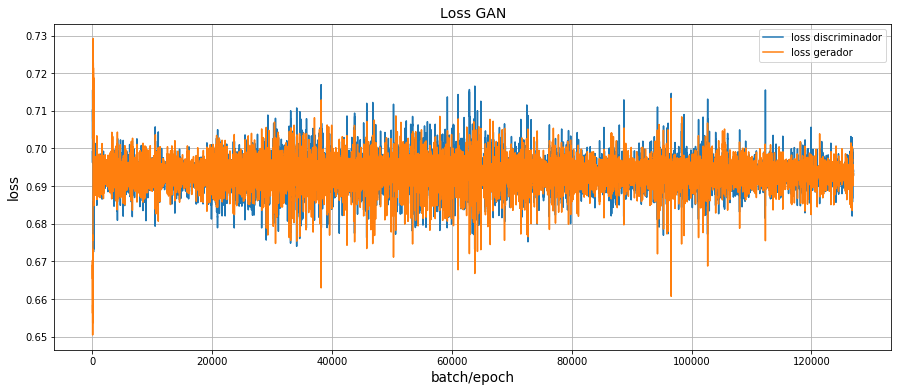

In [74]:
g_loss, d_loss = gan.get_loss()

plt.figure(figsize=(15,6))
#plt.plot(range(len(g_loss)), g_loss)
plt.title("Loss GAN", fontsize=14)
plt.ylabel("loss", fontsize=13.5)
plt.xlabel("batch/epoch", fontsize=13.5)
plt.plot(range(np.array(d_loss).shape[0]), np.array(d_loss), label="loss discriminador")
plt.plot(range(np.array(g_loss).shape[0]), np.array(g_loss), label="loss gerador")
#plt.plot(range(np.array(g_loss).shape[0]), 0.5*np.ones(np.array(g_loss).shape[0]),
#         color="black", label="objetivo", linestyle='--')
plt.grid()
#plt.yticks([0, 0.5,1,1.5,2,2.5,3,3.5,4,4.5,5])
plt.legend();

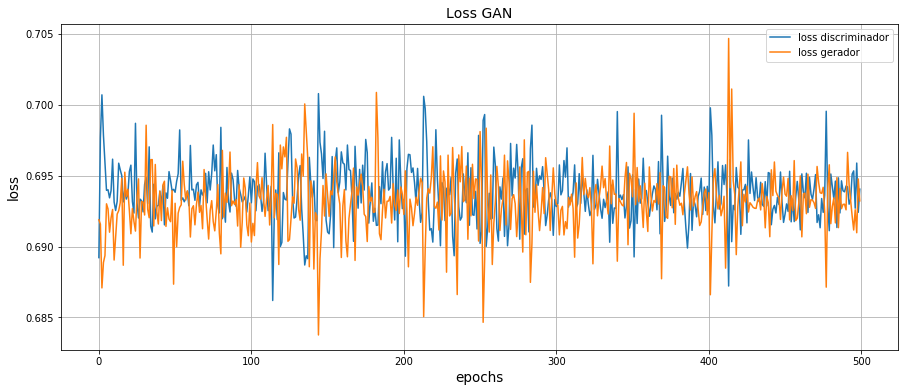

In [77]:
plt.figure(figsize=(15,6))
plt.title("Loss GAN", fontsize=14)
plt.ylabel("loss", fontsize=13.5)
plt.xlabel("epochs", fontsize=13.5)
plt.plot(range(len(gan.d_lpe)), np.array(gan.d_lpe), label="loss discriminador")
plt.plot(range(len(gan.g_lpe)), np.array(gan.g_lpe), label="loss gerador")
#plt.plot(range(np.array(g_loss).shape[0]), 0.5*np.ones(np.array(g_loss).shape[0]),
#         color="black", label="objetivo", linestyle='--')
plt.grid()
plt.legend();

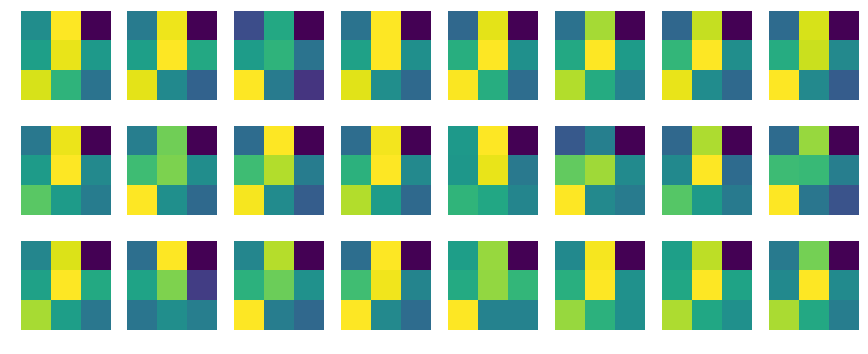

In [33]:
num_imgs = 24 #número de imágenes a mostrar aleatoriamente
img_pre = gan.G.predict(np.random.normal(0,1,(num_imgs,100)))
fig = plt.figure(figsize=(15,6))
for i in range(num_imgs):
    ax=fig.add_subplot(3,8,i+1)
    img = img_pre[i]
    plt.imshow(img.reshape((3,3)))
    ax.axis("off")
plt.show()

In [63]:
num_imgs = 100
fakes = gan.G.predict(np.random.normal(0,1,(num_imgs,100)))
print("imagens fake: ", fakes.shape)
fakes = fakes.reshape(num_imgs,9)
print("re-dimesionalidade: ", fakes.shape)
pca2 = PCA(n_components=2)
pca2.fit(X_img.reshape(X_img.shape[0],9))

X_real = pca2.transform(X_img.reshape(X_img.shape[0],9))
X_fake = pca2.transform(fakes)

imagens fake:  (100, 3, 3, 1)
re-dimesionalidade:  (100, 9)


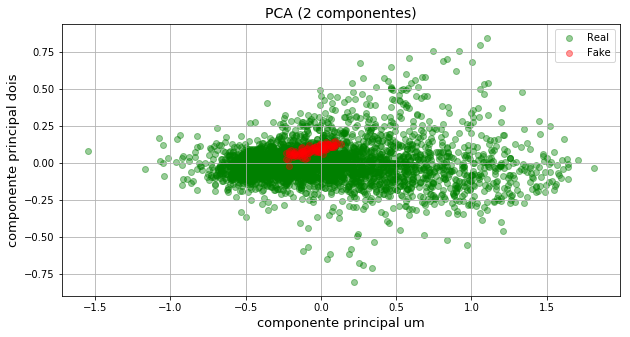

In [66]:
plt.figure(figsize=(10,5))
plt.title("PCA (2 componentes)", fontsize=14)
plt.xlabel("componente principal um", fontsize=13)
plt.ylabel("componente principal dois", fontsize=13)
plt.grid()
plt.scatter(X_real[:,0], X_real[:,1], color="green", alpha=.4, label="Real")
plt.scatter(X_fake[:,0], X_fake[:,1], color="red", alpha=.4, label="Fake")
plt.legend();